# Importar bibliotecas

Se comienza el proyecto importando las bibliotecas; en este caso importaremos bibliotecas de manejos de datos como Pandas y NumPy, bibliotecas de visualización como Seaborn y Matplotlib, y bibliotecas de análisis estadístico como SciPy Stats y Statsmodels API.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Importar Dataset

Se importa el conjunto de datos con nombres de columnas más descriptivos:

In [2]:
columnNames = ["ID", "Lago", "Alcalinidad", "pH", "Calcio", "Clorofila", "Mercurio", 
               "N_Peces", "MinMercurio", "MaxMercurio", "Estimacion", "Edad"]

df = pd.read_csv("https://raw.githubusercontent.com/crisb-7/Mercurio/main/mercurio.csv", 
                 names = columnNames, header = 0)

# Exploración del Dataset

Se realiza una exploración rápida del conjunto de datos para familiarizarse con las variables: el tipo de variable, sus rangos o valores, medidas de tendencia central y distribución, etc.

In [3]:
df.head()

,ID,Lago,Alcalinidad,pH,Calcio,Clorofila,Mercurio,N_Peces,MinMercurio,MaxMercurio,Estimacion,Edad
0,1,Alligator,5.9,6.1,3.0,0.7,1.23,5,0.85,1.43,1.53,1
1,2,Annie,3.5,5.1,1.9,3.2,1.33,7,0.92,1.90,1.33,0
2,3,Apopka,116.0,9.1,44.1,128.3,0.04,6,0.04,0.06,0.04,0
3,4,Blue Cypress,39.4,6.9,16.4,3.5,0.44,12,0.13,0.84,0.44,0
4,5,Brick,2.5,4.6,2.9,1.8,1.20,12,0.69,1.50,1.33,1


In [4]:
df = df.drop(columns = "ID")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Lago         53 non-null     object 
 1   Alcalinidad  53 non-null     float64
 2   pH           53 non-null     float64
 3   Calcio       53 non-null     float64
 4   Clorofila    53 non-null     float64
 5   Mercurio     53 non-null     float64
 6   N_Peces      53 non-null     int64  
 7   MinMercurio  53 non-null     float64
 8   MaxMercurio  53 non-null     float64
 9   Estimacion   53 non-null     float64
 10  Edad         53 non-null     int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 4.7+ KB


No se presentan datos nulos en este conjunto de datos, se tienen 8 variables continuas, 1 variable discreta y dos categóricas.

In [6]:
df.duplicated().sum()

0

Se buscan registros duplicados y se observa que no es el caso. Ahora con las medidas de tendencia central y distribución:

In [7]:
df.describe()

,Alcalinidad,pH,Calcio,Clorofila,Mercurio,N_Peces,MinMercurio,MaxMercurio,Estimacion,Edad
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,37.530189,6.590566,22.201887,23.116981,0.527170,13.056604,0.279811,0.874528,0.513208,0.811321
std,38.203527,1.288449,24.932574,30.816321,0.341036,8.560677,0.226406,0.522047,0.338729,0.394998
min,1.200000,3.600000,1.100000,0.700000,0.040000,4.000000,0.040000,0.060000,0.040000,0.000000
25%,6.600000,5.800000,3.300000,4.600000,0.270000,10.000000,0.090000,0.480000,0.250000,1.000000
50%,19.600000,6.800000,12.600000,12.800000,0.480000,12.000000,0.250000,0.840000,0.450000,1.000000
75%,66.500000,7.400000,35.600000,24.700000,0.770000,12.000000,0.330000,1.330000,0.700000,1.000000
max,128.000000,9.100000,90.700000,152.400000,1.330000,44.000000,0.920000,2.040000,1.530000,1.000000


Calculamos el sesgo de las variables numéricas:

In [8]:
df.skew(numeric_only=True)

Alcalinidad    1.025218
pH            -0.260433
Calcio         1.381819
Clorofila      2.555912
Mercurio       0.634074
N_Peces        2.733667
MinMercurio    1.136427
MaxMercurio    0.492097
Estimacion     1.000939
Edad          -1.638133
dtype: float64

Alcalinidad, Calcio, Clorofila, Número de peces, Min Mercurio, y Estimación tienen un sesgo muy alto. La variable de respuesta, Mercurio, también está moderadamente sesgada. También se calcula la curtosis de las variables numéricas:

In [9]:
df.kurtosis(numeric_only=True)

Alcalinidad   -0.287629
pH            -0.463142
Calcio         0.951908
Clorofila      7.233473
Mercurio      -0.471489
N_Peces        7.124486
MinMercurio    0.715167
MaxMercurio   -0.514945
Estimacion     0.906510
Edad           0.708793
dtype: float64

Clorofila y Número de peces tienen una curtosis muy alta.

# Prueba de Hipótesis

Una pregunta de investigación que surge en la exploración de los datos es: ¿la media del nivel máximo de mercurio en los peces de los lagos de Florida será **mayor** al nivel permitido de concentración de mercurio (0.5 mg Hg/kg) según regulación internacional?

A partir de esta pregunta, se identifica inmediatamente el modelo estadístico para contestarla: la prueba de hipótesis. En consecuencia, se procede a plantear las hipótesis a probar, a saber:
$$
H_0: ~ \mu_{\text{Hg-max}} = 0.5 \\
H_a: ~ \mu_{\text{Hg-max}} > 0.5
$$

donde $\mu_{\text{Hg}}$ es la media poblacional del nivel mercurio máximo encontrado en los peces de los lagos.

Para la **regla de decision**, se tomará un nivel de significancia común de $\alpha = 0.05$.

## Prueba de normalidad

Antes de proceder directamente con la prueba de hipótesis, se debe hacer una prueba de bondad de ajuste de los datos a una distribución normal; es decir, una prueba de normalidad. Esto con la intención de usar la distribución adecuada para la prueba de hipótesis. 

Como en cualquier prueba de bondad de ajuste, las hipótesis toman la forma

$$
H_0: f(x) = f_0(x) \\
H_a: f(x) \neq f_0(x)
$$

donde $f(x)$ es la distribución de las medias de nivel máximo de mercurio, y $f_0(x)$ es una distribución normal. Se realiza una prueba de normalidad de Shapiro-Wilk con la biblioteca SciPy. Se tomará un nivel de significancia de $\alpha = 0.05$.

In [28]:
alpha = 0.05
norm_stat, norm_pvalue= stats.shapiro(df.MaxMercurio)

print("p-value Normalidad:", norm_pvalue)

p-value Normalidad: 0.04671917110681534


Ya que el p-value resultó menor que el nivel de significancia determinado, se rechaza la hipótesis nula. Por tanto, se concluye con una confianza del 95% que la distribución de los datos no es una normal. Esto puede comprobarse gráficamente con un QQ-plot:

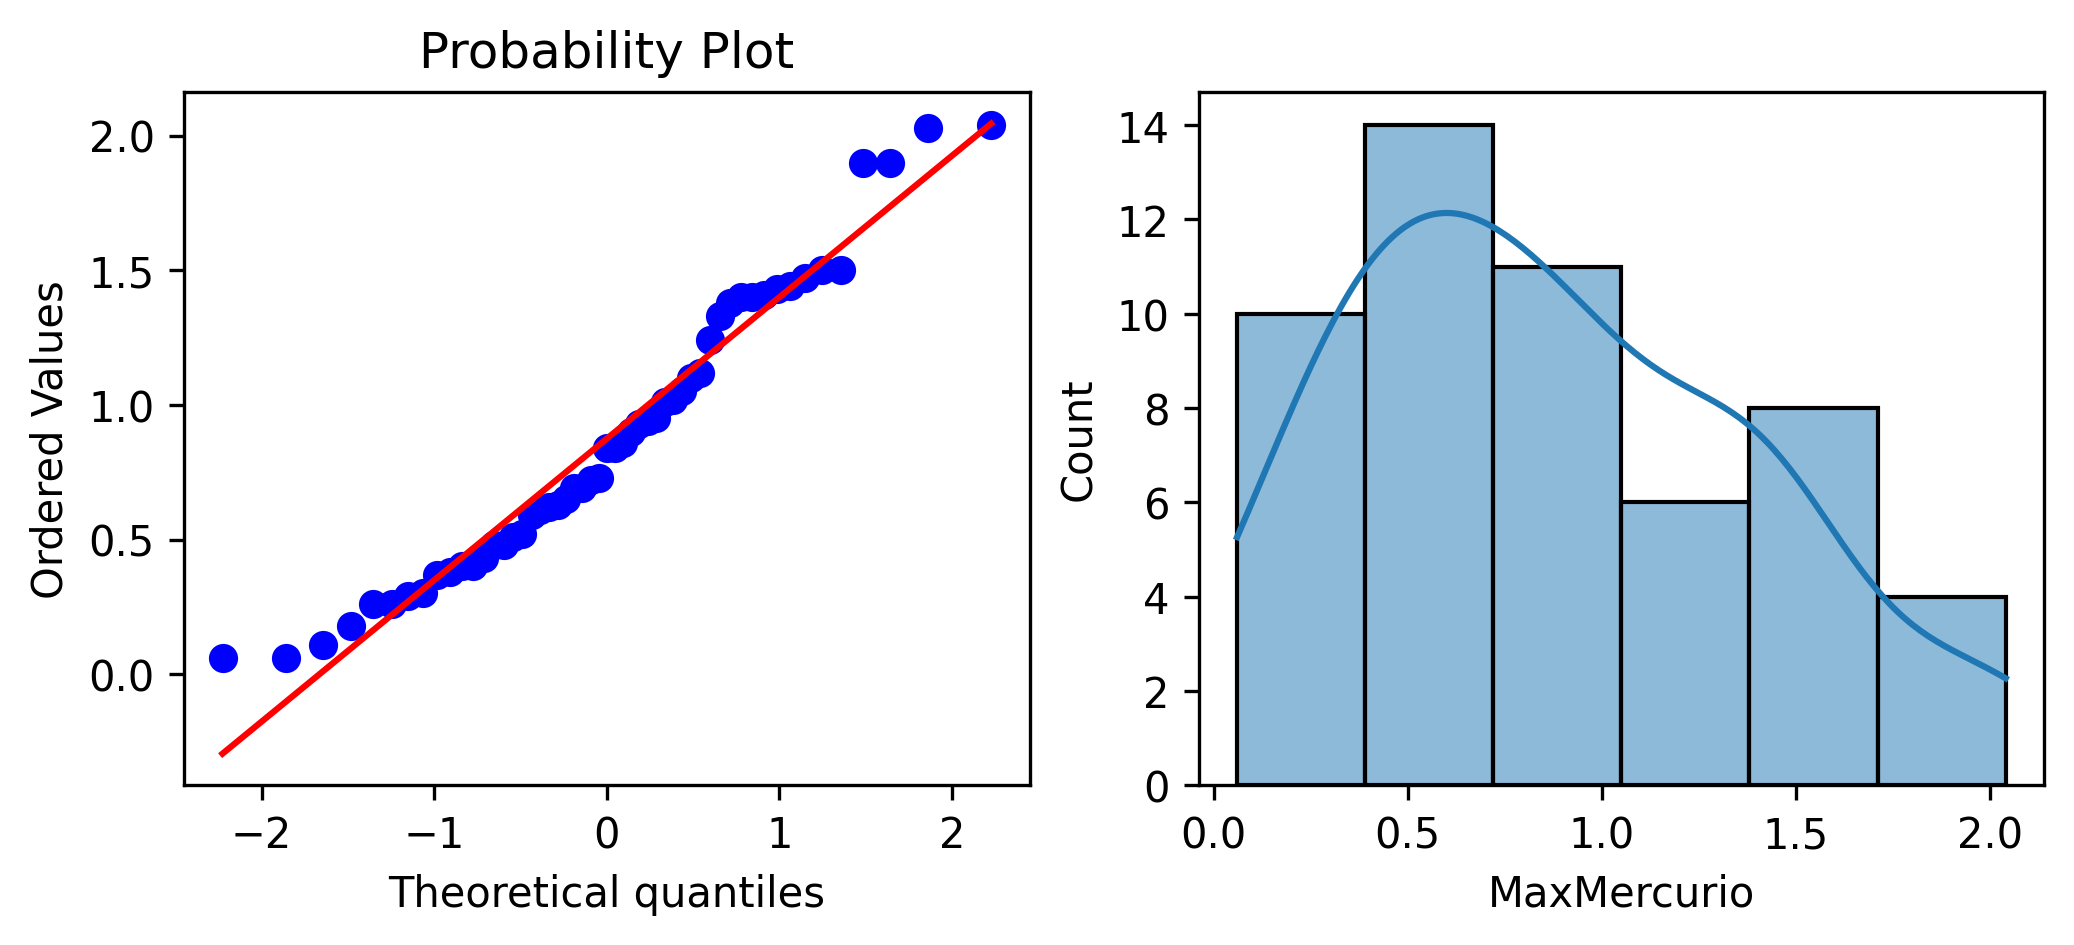

In [29]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
stats.probplot(df.MaxMercurio, plot = axes[0])
sns.histplot(data = df, x = "MaxMercurio", bins = 6, kde = True, ax = axes[1])
plt.show()

Puede observarse que la distribución no es una normal debido su sesgo, porque los datos tienen un ajuste relativamente razonable a los niveles teóricos; esto se debe a la naturaleza de la variable aleatoria, ya que en la práctica el nivel mínimo de mercurio no puede ser menor que cero, y los niveles no son muy altos como para desplazar la distribución lo suficiente como para que, en efecto, siga una normal. Lo anterior cobra sentido al observar el sesgo de los datos:

In [30]:
df.MaxMercurio.skew()

0.4920966176197896

Además, si observamos la curtosis

In [31]:
df.MaxMercurio.kurtosis()

-0.5149449394161021

Puede verse que la distribución tiene un sesgo a la derecha importante, además de ser una distribución platicúrtica. Por estas razones, se optará por realizar la prueba de hipótesis con una distribución t de Student.

## Prueba $t$ y conclusión

Se procede a computar la prueba de hipótesis con la distribución t de Student utilizando la función ttest_1samp() de SciPy. Se ingresa la media poblacional deseada (0.5 mg Hg/kg), y se especifica la hipótesis alternativa pertinente para que la función regrese el p-value correcto.

In [32]:
tstat, pvalue = stats.ttest_1samp(df.MaxMercurio, popmean=0.5, alternative="greater")

print("t Statistic:", tstat)
print("p-value:", pvalue)

t Statistic: 5.222916354699773
p-value: 1.5713546452646114e-06


Se observa que el p-value es considerablemente menor que el nivel de significancia $\alpha$, por lo cual se rechaza la hipótesis nula. Puede visualizarse le resultado junto con la regla de decisión de la prueba utilizando el estadístico de prueba. Primero se comprueba que, en efecto, el p-value retornado sea el adecuado:

In [33]:
1 - stats.t.cdf(tstat, len(df)-1)

1.5713546452911231e-06

Y se observa que el valor obtenido mediante el complemento de la función de densidad de probabilidad acumulada (p-value adecuado para las hipótesis planteadas) coincide con el p-value retornado por ttest_1samp(). Ahora, visualizando este valor:

In [34]:
t0 = abs(stats.t.ppf(alpha, len(df) - 1))

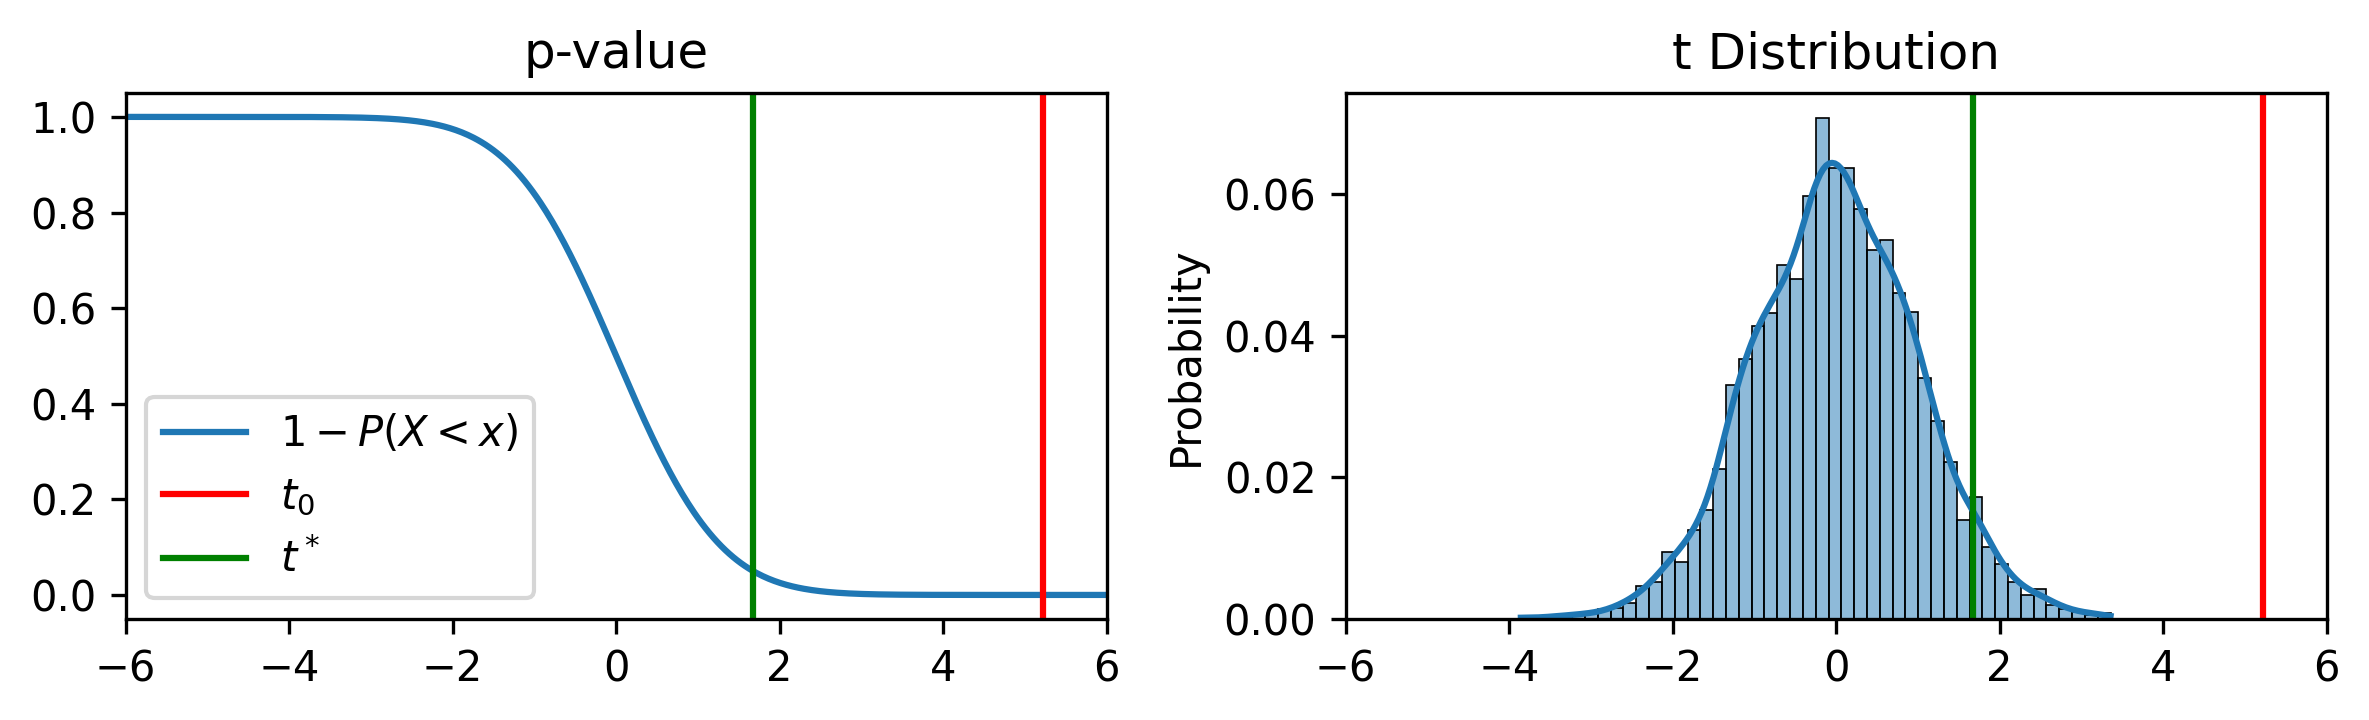

In [68]:
t = np.linspace(-6,6, 500)

fig, axes = plt.subplots(1,2, figsize =(8,2.5))

axes[0].plot(t, 1 - stats.t.cdf(t, len(df)-1), label = r"$1-P(X < x)$")
axes[0].axvline(x=tstat, color = "r", label = r"$t_0$")
axes[0].axvline(x=t0, color = "g", label = r"$t^*$")
axes[0].legend()
axes[0].set_xlim([-6, 6])
axes[0].set_title("p-value")
# axes[0].grid(True)

sns.histplot(x = stats.t.rvs(len(df)-1, size = 5000), kde = True, stat = "probability", ax = axes[1])
axes[1].set_title("t Distribution")
axes[1].set_xlim([-6, 6])
# axes[1].grid(True)
axes[1].axvline(x=tstat, color = "r")
axes[1].axvline(x=t0, color = "g", label = r"$t^*$")

plt.tight_layout()
plt.show()

Es evidente que el estadístico de prueba $t_0$ está dentro de la zona de rechazo. Por lo tanto, se concluye con un nivel de significancia del 95% que la media del nivel máximo de mercurio de los lagos de Florida es mayor al nivel máximo de mercurio establecido por reglamentos internacionales. Finalmente podemos graficar el intervalo de confianza de este resultado:

In [36]:
std_err = df.Mercurio.std()/np.sqrt(len(df))

el = df.Mercurio.mean() - abs(stats.t.ppf(alpha/2, len(df) - 1))*std_err
er = df.Mercurio.mean() + abs(stats.t.ppf(alpha/2, len(df) - 1))*std_err

elMin = df.MinMercurio.mean() - abs(stats.t.ppf(alpha/2, len(df) - 1))*(df.MinMercurio.std()/np.sqrt(len(df)))
erMin = df.MinMercurio.mean() + abs(stats.t.ppf(alpha/2, len(df) - 1))*(df.MinMercurio.std()/np.sqrt(len(df)))

elMax = df.MaxMercurio.mean() - abs(stats.t.ppf(alpha/2, len(df) - 1))*(df.MaxMercurio.std()/np.sqrt(len(df)))
erMax = df.MaxMercurio.mean() + abs(stats.t.ppf(alpha/2, len(df) - 1))*(df.MaxMercurio.std()/np.sqrt(len(df)))

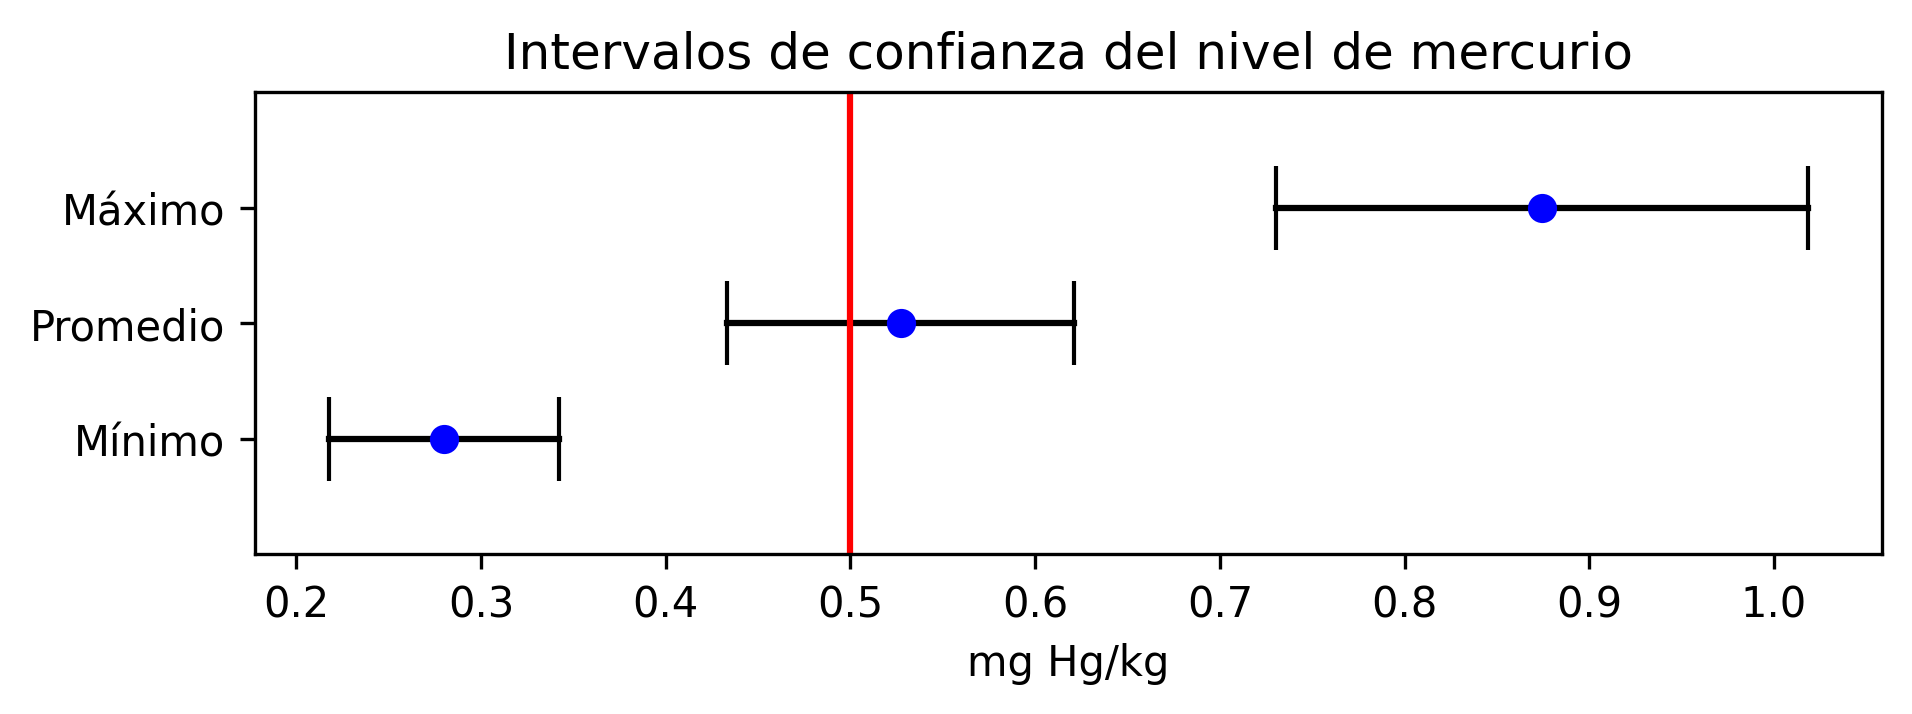

In [37]:
fig, ax = plt.subplots(figsize=(7,2))

ax.plot([elMin, erMin], [1, 1], color = "k", marker = "|", markersize=20)
ax.plot(df.MinMercurio.mean(), [1], marker = "o", color = "b")

ax.plot([el, er], [2, 2], color = "k", marker = "|", markersize=20)
ax.plot(df.Mercurio.mean(), [2], marker = "o", color = "b")

ax.plot([elMax, erMax], [3, 3], color = "k", marker = "|", markersize=20)
ax.plot(df.MaxMercurio.mean(), [3], marker = "o", color = "b")

ax.set_yticks([1, 2, 3], ["Mínimo", "Promedio", "Máximo"])

ax.axvline(x=0.5, color = "r")

ax.set_title("Intervalos de confianza del nivel de mercurio")
ax.set_xlabel("mg Hg/kg")
ax.set_ylim([0,4])
plt.show()

Se observa que el nivel máximo de mercurio reglamentario se encuentra fuera del intervalo de confianza del 95% del máximo. Por esa razón puede decirse que la media poblacional es mayor que el máximo nivel permitido.

# ANOVA - Edad

El segundo modelo estadístico a implementar en el análisis es el ANOVA; este nos permitirá identificar si una variable categórica, en este caso la edad del pez (joven o maduro) es un factor significativo en el nivel de mercurio. Además, esta herramienta nos ayudará a elucidar la pregunta de investigación más general sobre los factores principales que influyen en la concentración de mercurio en los peces. Se utilizará la función anova_stat() de BioInfoKit para realizar el ANOVA. El modelo toma la forma

$$
Y_{ij} = \mu_i + \varepsilon_{ij}
$$

y, recordando la prueba de hipótesis del modelo,

$$
H_0: ~\mu_1 = \mu_2 \\
H_a: ~ \mu_1 \neq \mu_2
$$

donde $\mu_1$ es la media de las observaciones de mercurio promedio en los lagos con peces jóvenes, y $\mu_2$ es la media de mercurio en la muestra de lagos con peces maduros. **Todas las pruebas de hipótesis realizadas en el análisis se realizarán con un nivel de significancia de** $\alpha = 0.05$.

In [10]:
from bioinfokit.analys import stat

m = ols("Mercurio ~ C(Edad)", data = df).fit()
table = sm.stats.anova_lm(m)

res = stat()
res.anova_stat(df = df, res_var = 'Mercurio', anova_model = 'Mercurio ~ C(Edad)')
res.anova_summary.round(4)

,df,sum_sq,mean_sq,F,PR(>F)
C(Edad),1.0,0.0715,0.0715,0.6102,0.4383
Residual,51.0,5.9764,0.1172,NaN,NaN


Se obtiene un estadístico F bajo, con un p-value mucho mayor que $\alpha$; esto indica que no hay evidencia suficiente para afirmar con una significancia del 95% que las medias son diferentes, por lo tanto, se concluye con el mismo nivel de significancia que la concentración media de mercurio en los peces jóvenes es igual a la concentración en peces maduros.

Además, puede realizarse una prueba de Tukey para identificar los intervalos de confianza de las respectivas medias analizadas:

In [11]:
tukey = pairwise_tukeyhsd(endog = df['Mercurio'],
                          groups = df['Edad'],
                          alpha = 0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0939 0.4383 -0.1474 0.3352  False
---------------------------------------------------


La prueba regresa un rechazo falso de la hipótesis, por lo cual se realiza la misma conclusión esbozada anteriomente. Visualizando los intervalos de confianza:

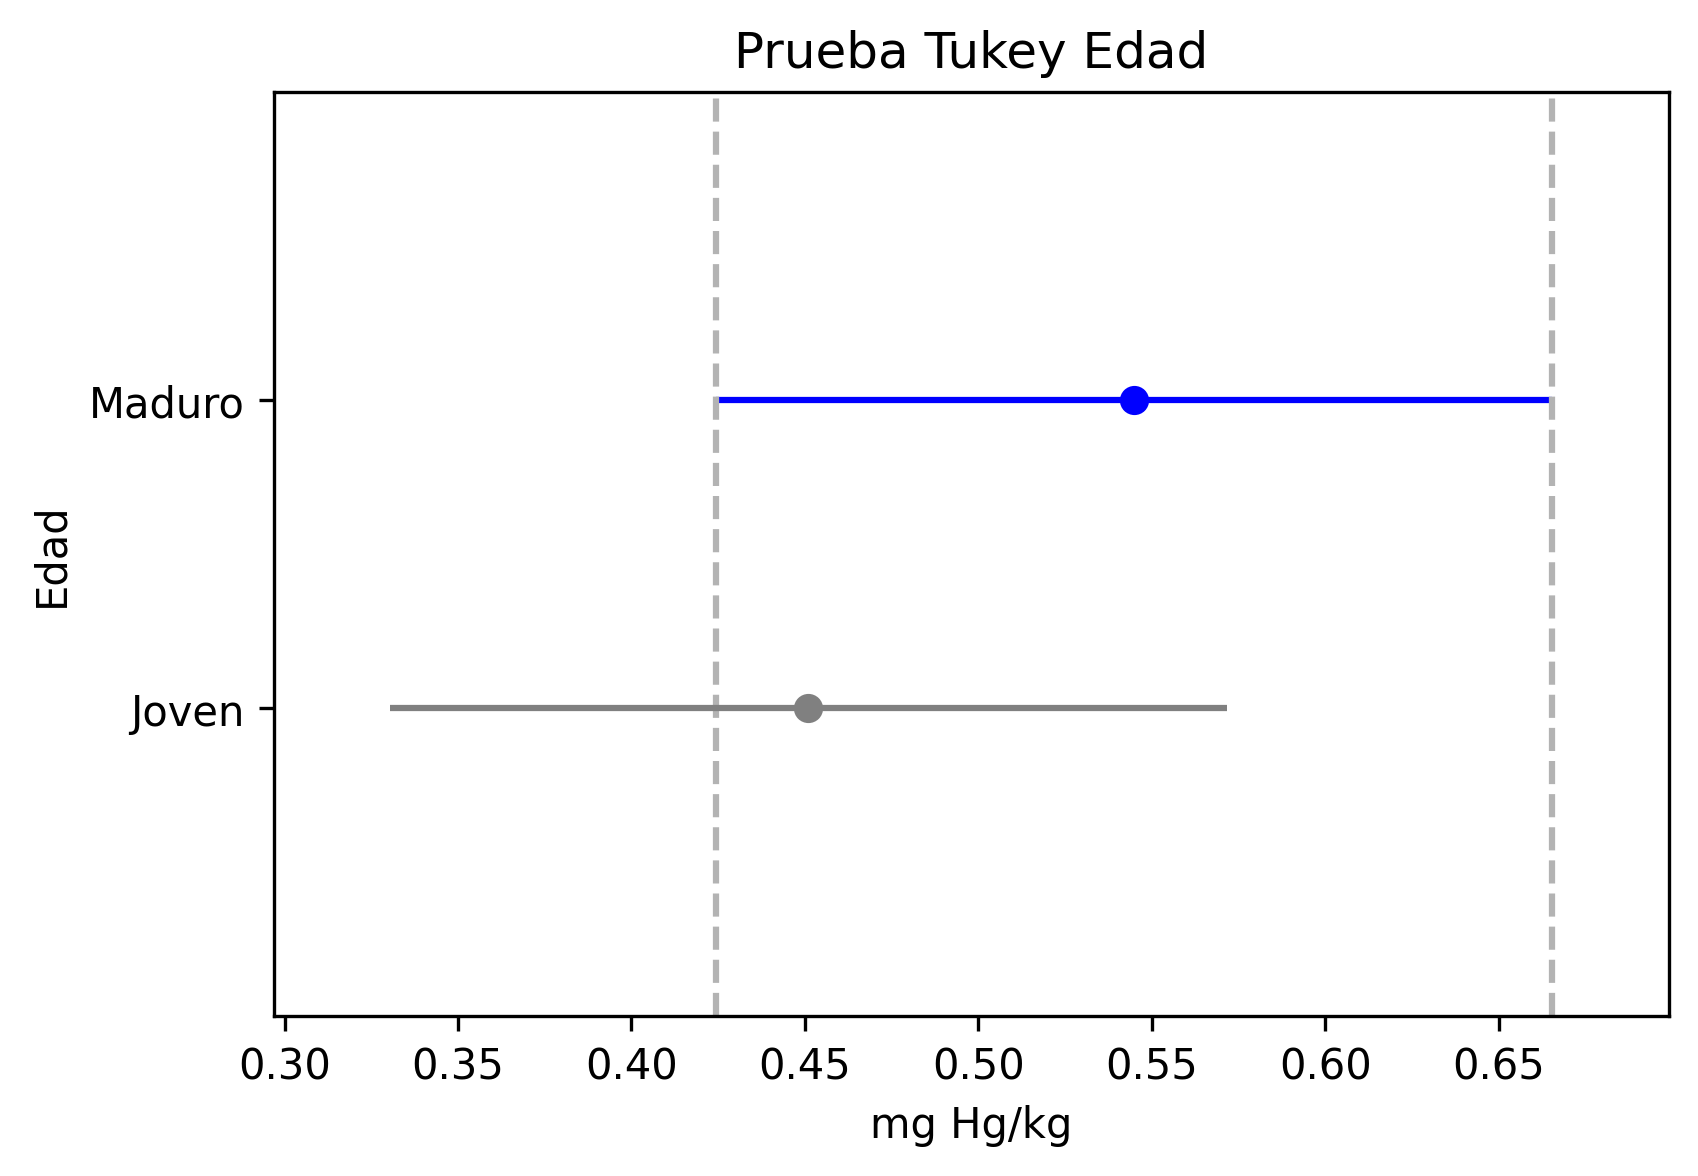

In [12]:
tukey.plot_simultaneous(comparison_name = 1, figsize = (6, 4), xlabel = r"mg Hg/kg", ylabel = "Edad")
plt.yticks(ticks = [0, 1], labels = ["Joven", "Maduro"])
plt.title("Prueba Tukey Edad")
plt.show()

Se nota claramente el traslape en los intervalos de confianza, por lo tanto, la edad no es un factor relevante en la concentración media de mercurio en los peces.

In [13]:
# df["Edad"] = df.Edad.map({0.0: "Joven", 1.0:"Maduro"})

## Verificación del modelo

Para que las conclusiones anteriores resulten verdaderas, se debe verificar que los supuestos del modelo. Se probarán las siguientes tres suposiciones del modelo:

1. Los residuos siguen una distribución normal
2. Las muestras provienen de distribuciones con varianzas idénticas
3. Los residuos del ANOVA son independientes

### Normalidad de las muestras

Se comienza con una prueba de Shapiro-Wilk de normalidad para comprobar que ambas muestras (tratamientos) siguen una distribución normal. Aprovechando el módulo de SciPy (stats),

In [14]:
aov_residuals = res.anova_std_residuals

In [15]:
stats.shapiro(aov_residuals)

ShapiroResult(statistic=0.9321757555007935, pvalue=0.004930485505610704)

Las pruebas regresan p-values contrapuestos: la distribución de los peces jóvenes sigue una distribución normal con una significancia del 95%, mientras que la muestra de los peces maduros retorna un p-value que obliga a rechazar esa conclusión. Pueden comprobarse las pruebas de Shapiro-Wilk de manera gráfica,

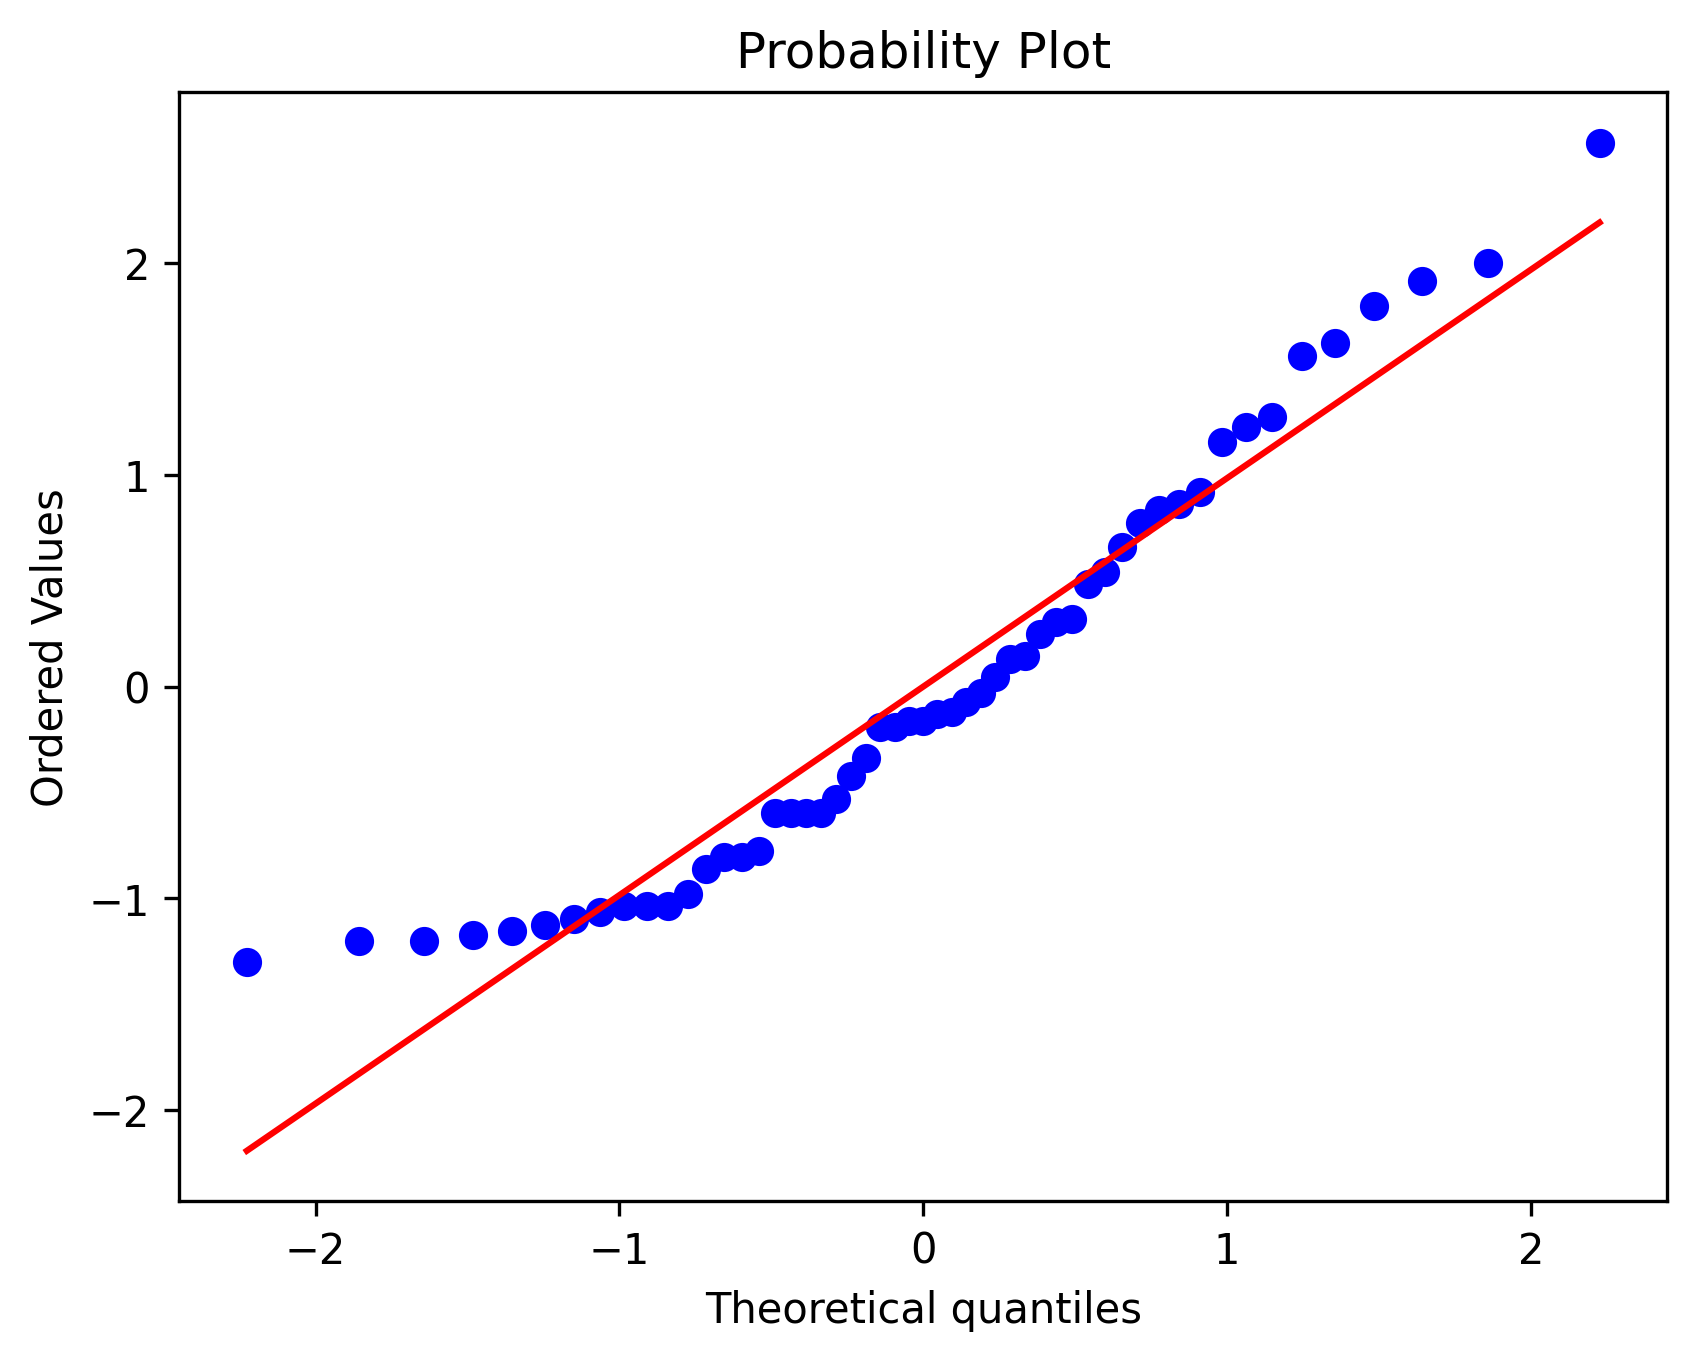

In [16]:
stats.probplot(aov_residuals, plot = plt)
plt.show()

Debido a que no se cumple esta condición, el ANOVA efectuado carece de validez. Es posible realizar una transformación de Box-Cox para que esta condición se cumpla.

# ANOVA - Edad con transformación de Box-Cox

Primero se aplica la transformación Box-Cox en la variable de respuesta, y volvemos a definir los vectores de interés para poder efectuar el ANOVA de nuevo.

In [17]:
mercurio, _ = stats.boxcox(df.Mercurio + 1e-13)

df_ANOVA = pd.DataFrame({"Mercurio":mercurio, "Edad":df.Edad})

jovenes = df_ANOVA.groupby("Edad").get_group(0).Mercurio
maduros = df_ANOVA.groupby("Edad").get_group(1).Mercurio

Una vez más se aplica tanto ols() como anova_stat() para este nuevo ANOVA,

In [18]:
m = ols("Mercurio ~ C(Edad)", data = df).fit()
table = sm.stats.anova_lm(m)

res = stat()
res.anova_stat(df = df_ANOVA, res_var = 'Mercurio', anova_model = 'Mercurio ~ C(Edad)')
res.anova_summary.round(4)

,df,sum_sq,mean_sq,F,PR(>F)
C(Edad),1.0,0.4307,0.4307,1.6654,0.2027
Residual,51.0,13.1882,0.2586,NaN,NaN


Es posible observar que el p-value es menos de la mitad que la ocasión anterior, no obstante, aún así se tiene un valor mayor que $\alpha$ por lo que la conclusión prevalece. Realizamos la misma prueba de Tukey y graficamos los intervalos de confianza,

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     0      1   0.2304 0.2027 -0.128 0.5888  False
--------------------------------------------------


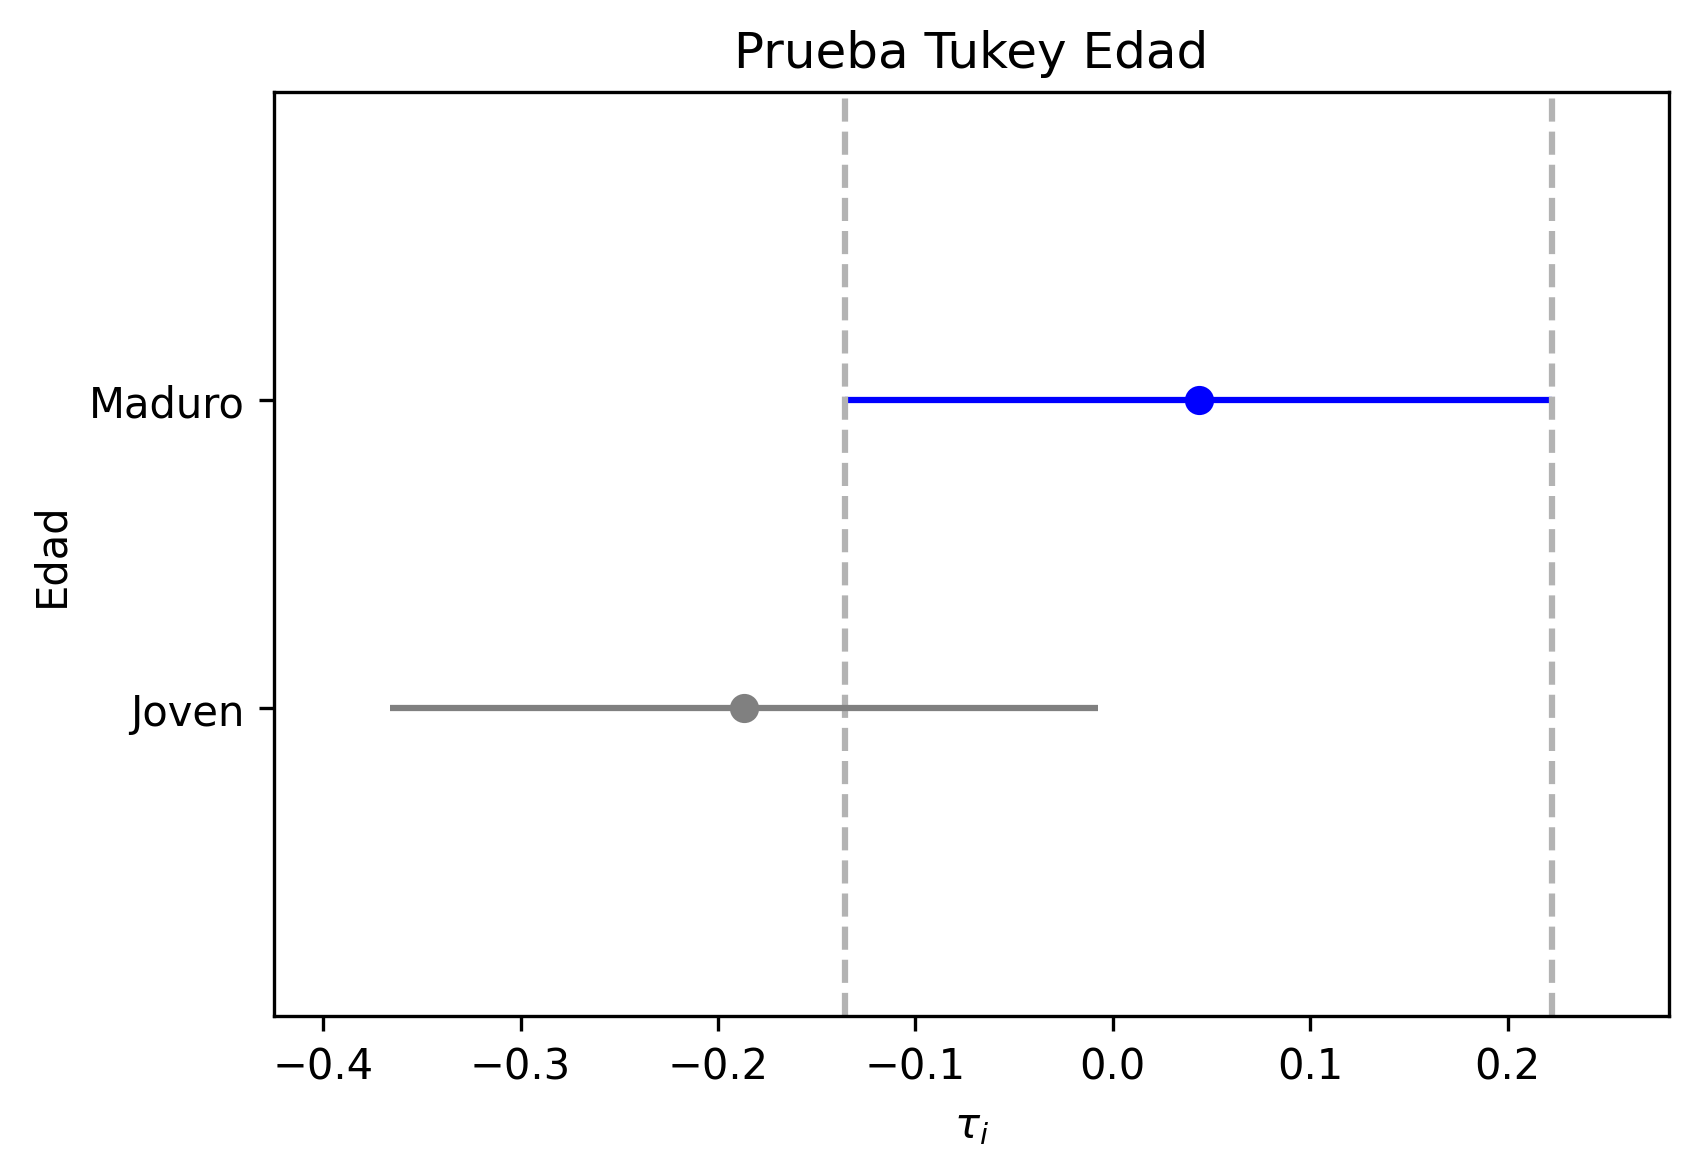

In [19]:
tukey = pairwise_tukeyhsd(endog = df_ANOVA['Mercurio'] - df_ANOVA.Mercurio.mean(),
                          groups = df_ANOVA['Edad'],
                          alpha = 0.05)
print(tukey)

tukey.plot_simultaneous(comparison_name = 1, figsize = (6, 4), xlabel = r"$\tau_i$", ylabel = "Edad")
plt.yticks(ticks = [0, 1], labels = ["Joven", "Maduro"])
plt.title("Prueba Tukey Edad")
plt.show()

Puede verse que la transformación afectó a los intervalos de manera importante, pues el intervalo de confianza de los peces maduros ya no incluye la media de los peces jóvenes. Sin embargo, los intervalos de confianza siguen traslapados por lo cual, junto con el estadístico F y su respectivo p-value, puede decirse con un nivel de significancia del 95% que la edad de los peces no es un factor importante en la concentración de mercurio en los peces.

## Verificación del ANOVA con Box-Cox

Se extraen los residuos del ANOVA para realizar el análisis:

In [20]:
aov_residuals = res.anova_std_residuals

### Prueba de normalidad

Una vez más realizamos la prueba de Shapiro-Wilk,

In [21]:
stats.shapiro(aov_residuals)

ShapiroResult(statistic=0.9761925935745239, pvalue=0.36681273579597473)

que en esta ocasión entrega un p-value mucho mayor que $\alpha$, por lo cual esta vez sí se cumple la condición de normalidad de los residuos. Graficando el QQ-plot,

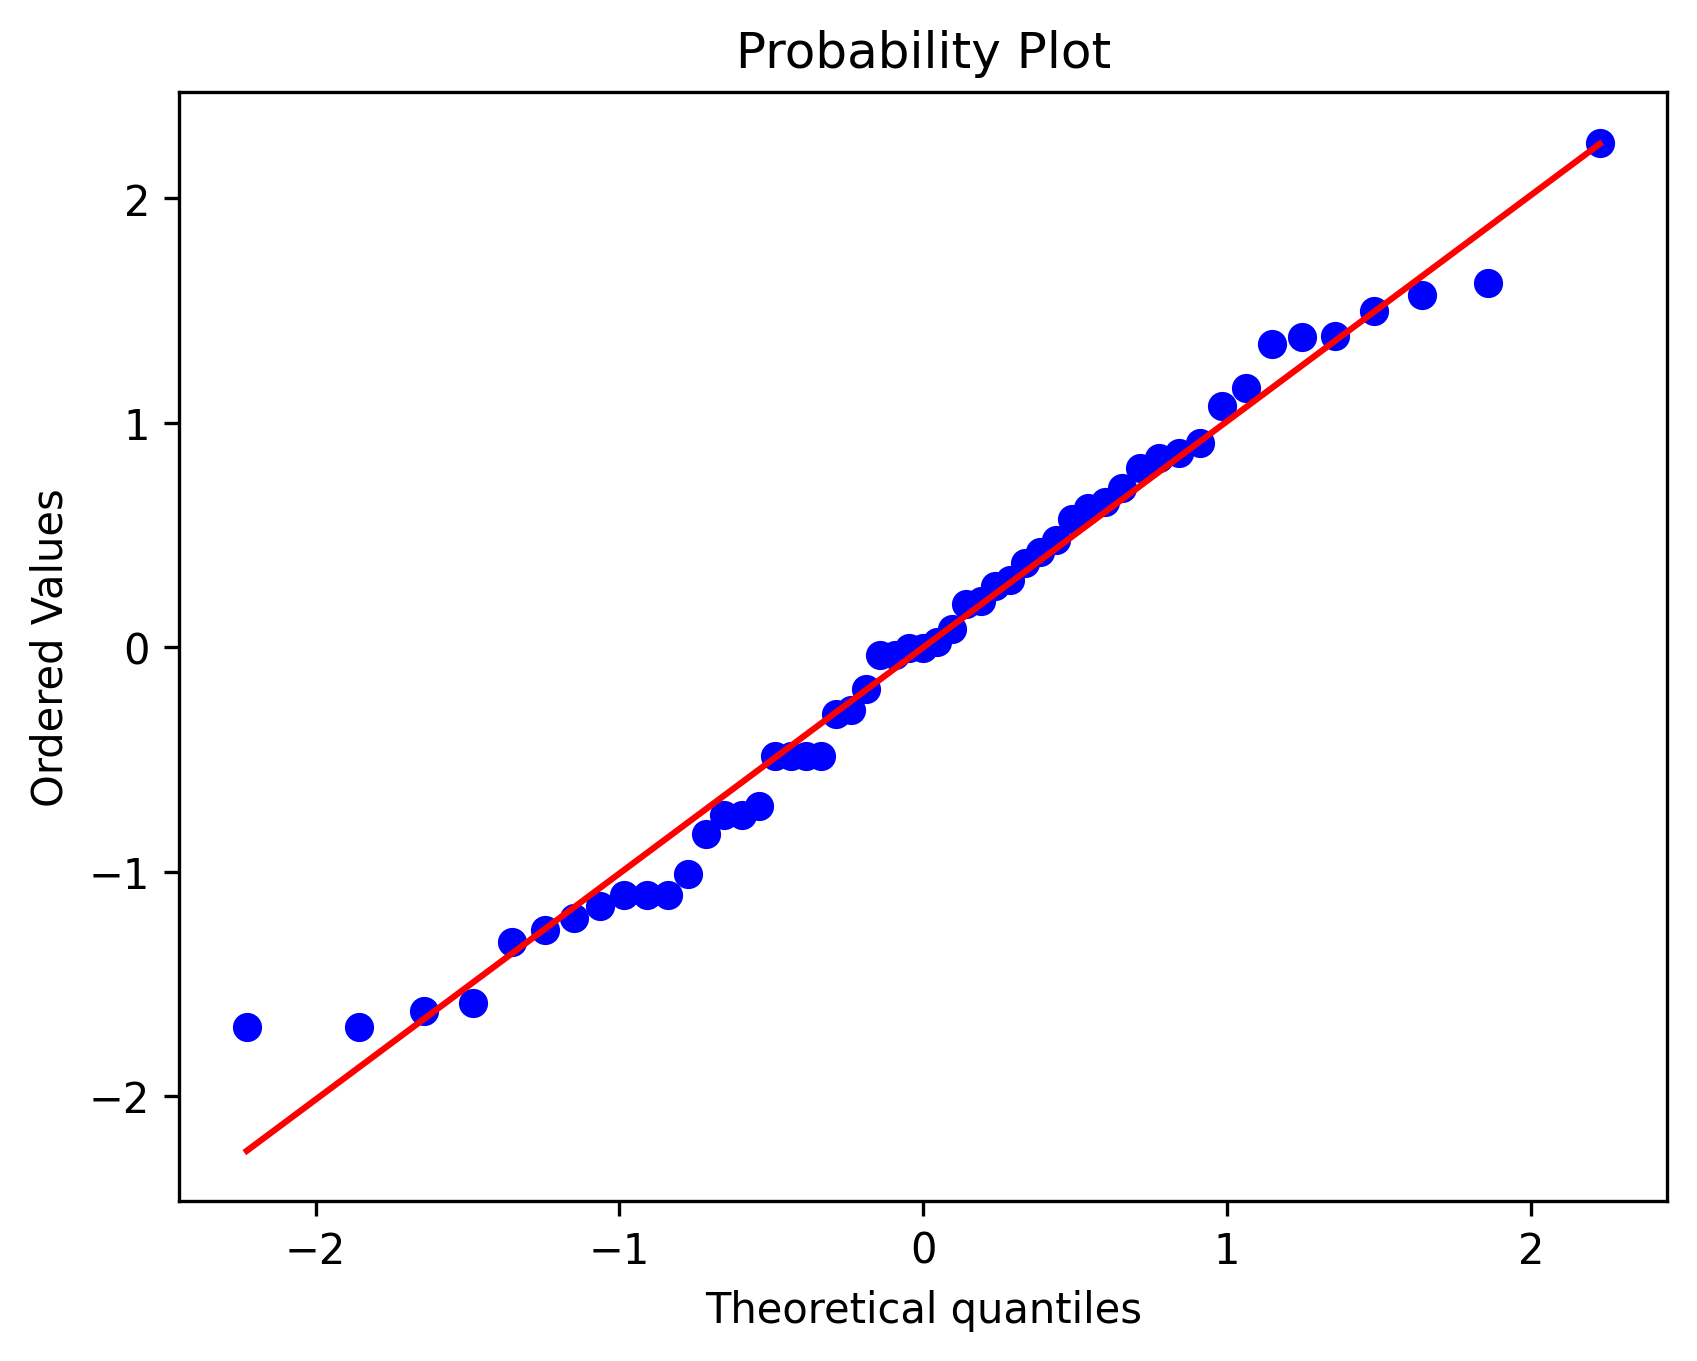

In [22]:
stats.probplot(aov_residuals, plot = plt)
plt.show()

se nota que existe un ajuste mucho más razonable a la línea recta, a pesar de que todavía presenta un ajuste pobre cerca de las colas.

### Varianza

Para el análisis de homocedasticidad se realiza una prueba de Levene para determinar si las varianzas de ambos tratamientos provienen de una varianza poblacional idéntica; es decir, las varianzas de las muestras son iguales de forma significativa. Para esto se emplea la prueba de Levene de SciPy,

In [23]:
s, p = stats.levene(jovenes, maduros, center = "mean")
print("p-value: " + str(round(p, 4)))

p-value: 0.1321


Sucede entonces que el p-value es mayor que $\alpha$, por cual que no se rechaza la hipótesis nula. Esto implica que las varianzas de las muestras son iguales, con un nivel de significancia del 95%, comprobando así la condición de homocedasticidad. Adicionalmente pueden graficarse los residuos contra los valores ajustados del ANOVA, 

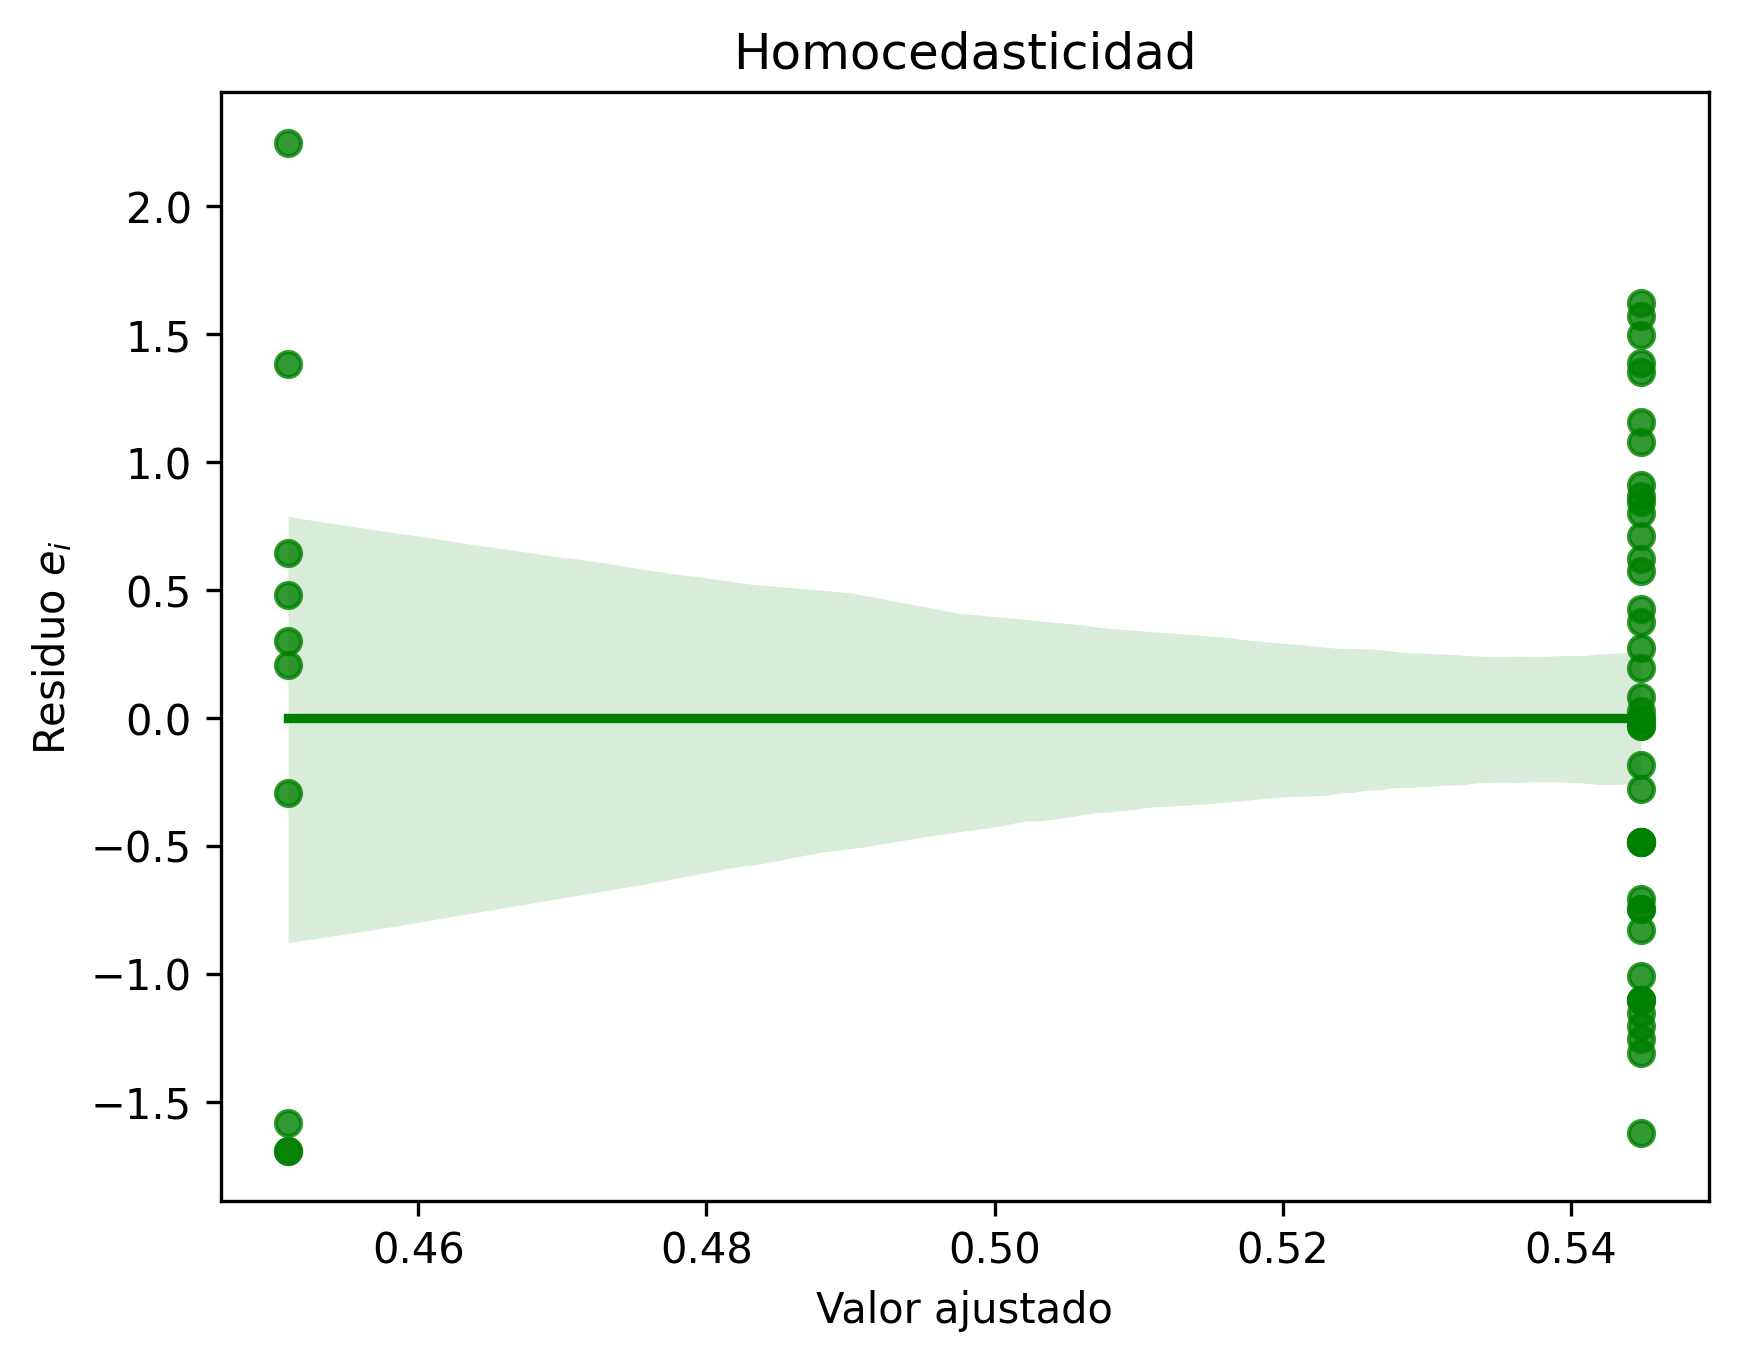

In [60]:
sns.regplot(x = m.fittedvalues, y = res.anova_std_residuals, color="green")
plt.title("Homocedasticidad")
plt.xlabel("Valor ajustado")
plt.ylabel(r"Residuo $e_i$")
plt.show()

Resaltando que la visualización de regresión de Seaborn indica una línea constante en $y$, además de que la dispersión de ambos conjuntos de datos es similar, se confirma gráficamente la prueba de Levene.

### Independencia

Se procede a compobar la condición de independencia de los residuos mediante una gráfica de los valores contra el número de residuo; es decir, el eje $y$ comprende los residuos $e_n$, mientras que el eje $x$ comprende el conjunto $n = \{1, 2, 3, ..., N \}$ donde N es el tamaño del vector de residuos.

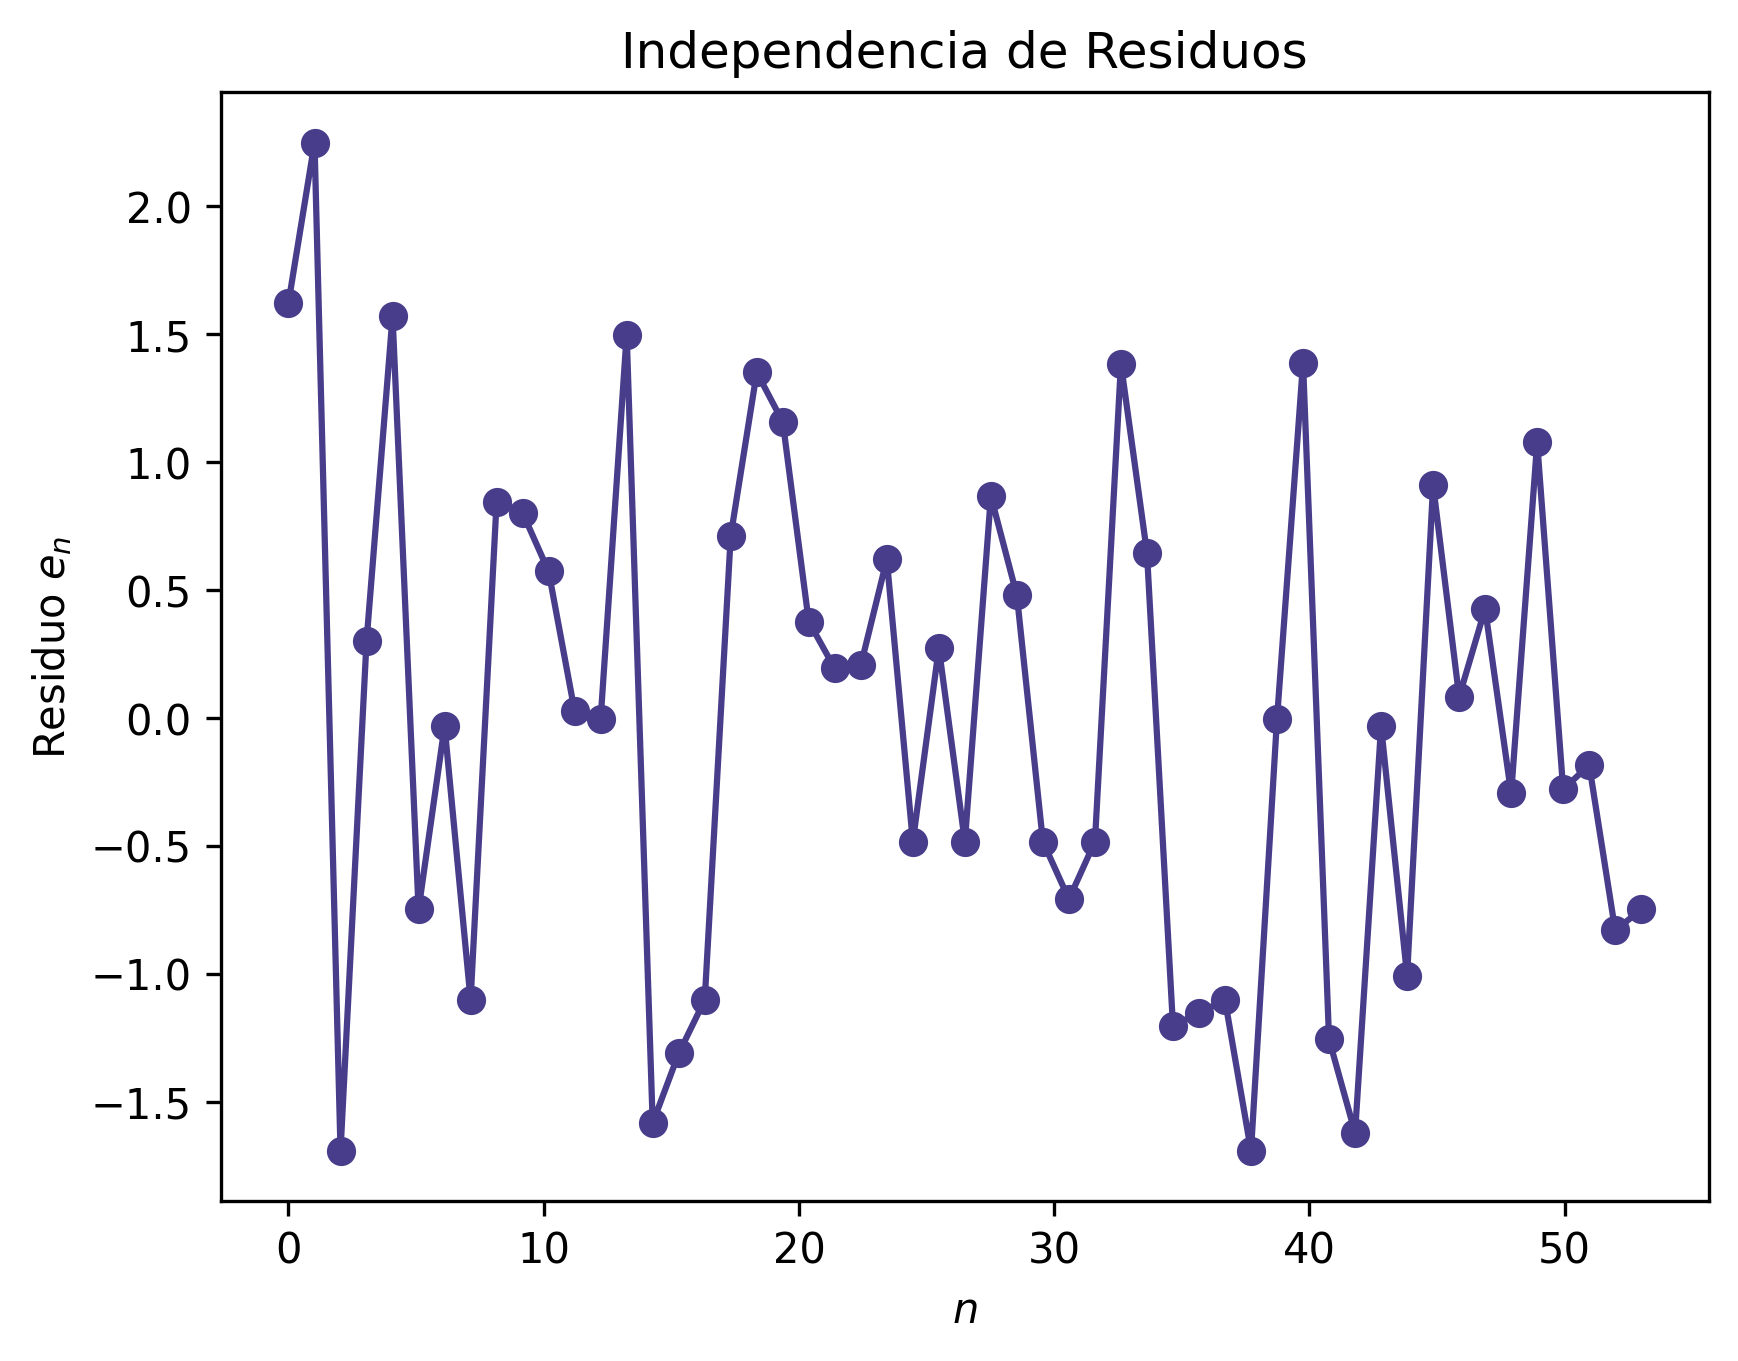

In [66]:
xn = np.linspace(0, len(df), len(df))
plt.plot(xn, res.anova_std_residuals, marker="o", color = "darkslateblue")
plt.title("Independencia de Residuos")
plt.ylabel(r"Residuo $e_n$")
plt.xlabel(r"$n$")
plt.show()

Es evidente que los residuos no presentan tendencias ya que oscilan de manera aleatoria entre valores positivos y negativos, de tal suerte que se comprueba gráficamente la condición de independencia

Habiendo comprobado todas las condiciones del ANOVA, se puede por fin afirmar la conclusión con certeza: la concentración media de mercurio en los peces jóvenes es igual a la concentración en peces maduros con un nivel de significancia del 95%.

# Regresión lineal

Es posible implementar una regresión lineal para intentar predecir el nivel medio de mercurio en los peces de los lagos de Florida. Este modelo se debe implementar utilizando variables independientes con mínima colinealidad, es decir, que las variables independientes tengan una correlación muy baja entre sí. Se visualiza un mapa de calor de las correlaciones entre las variables del conjunto,

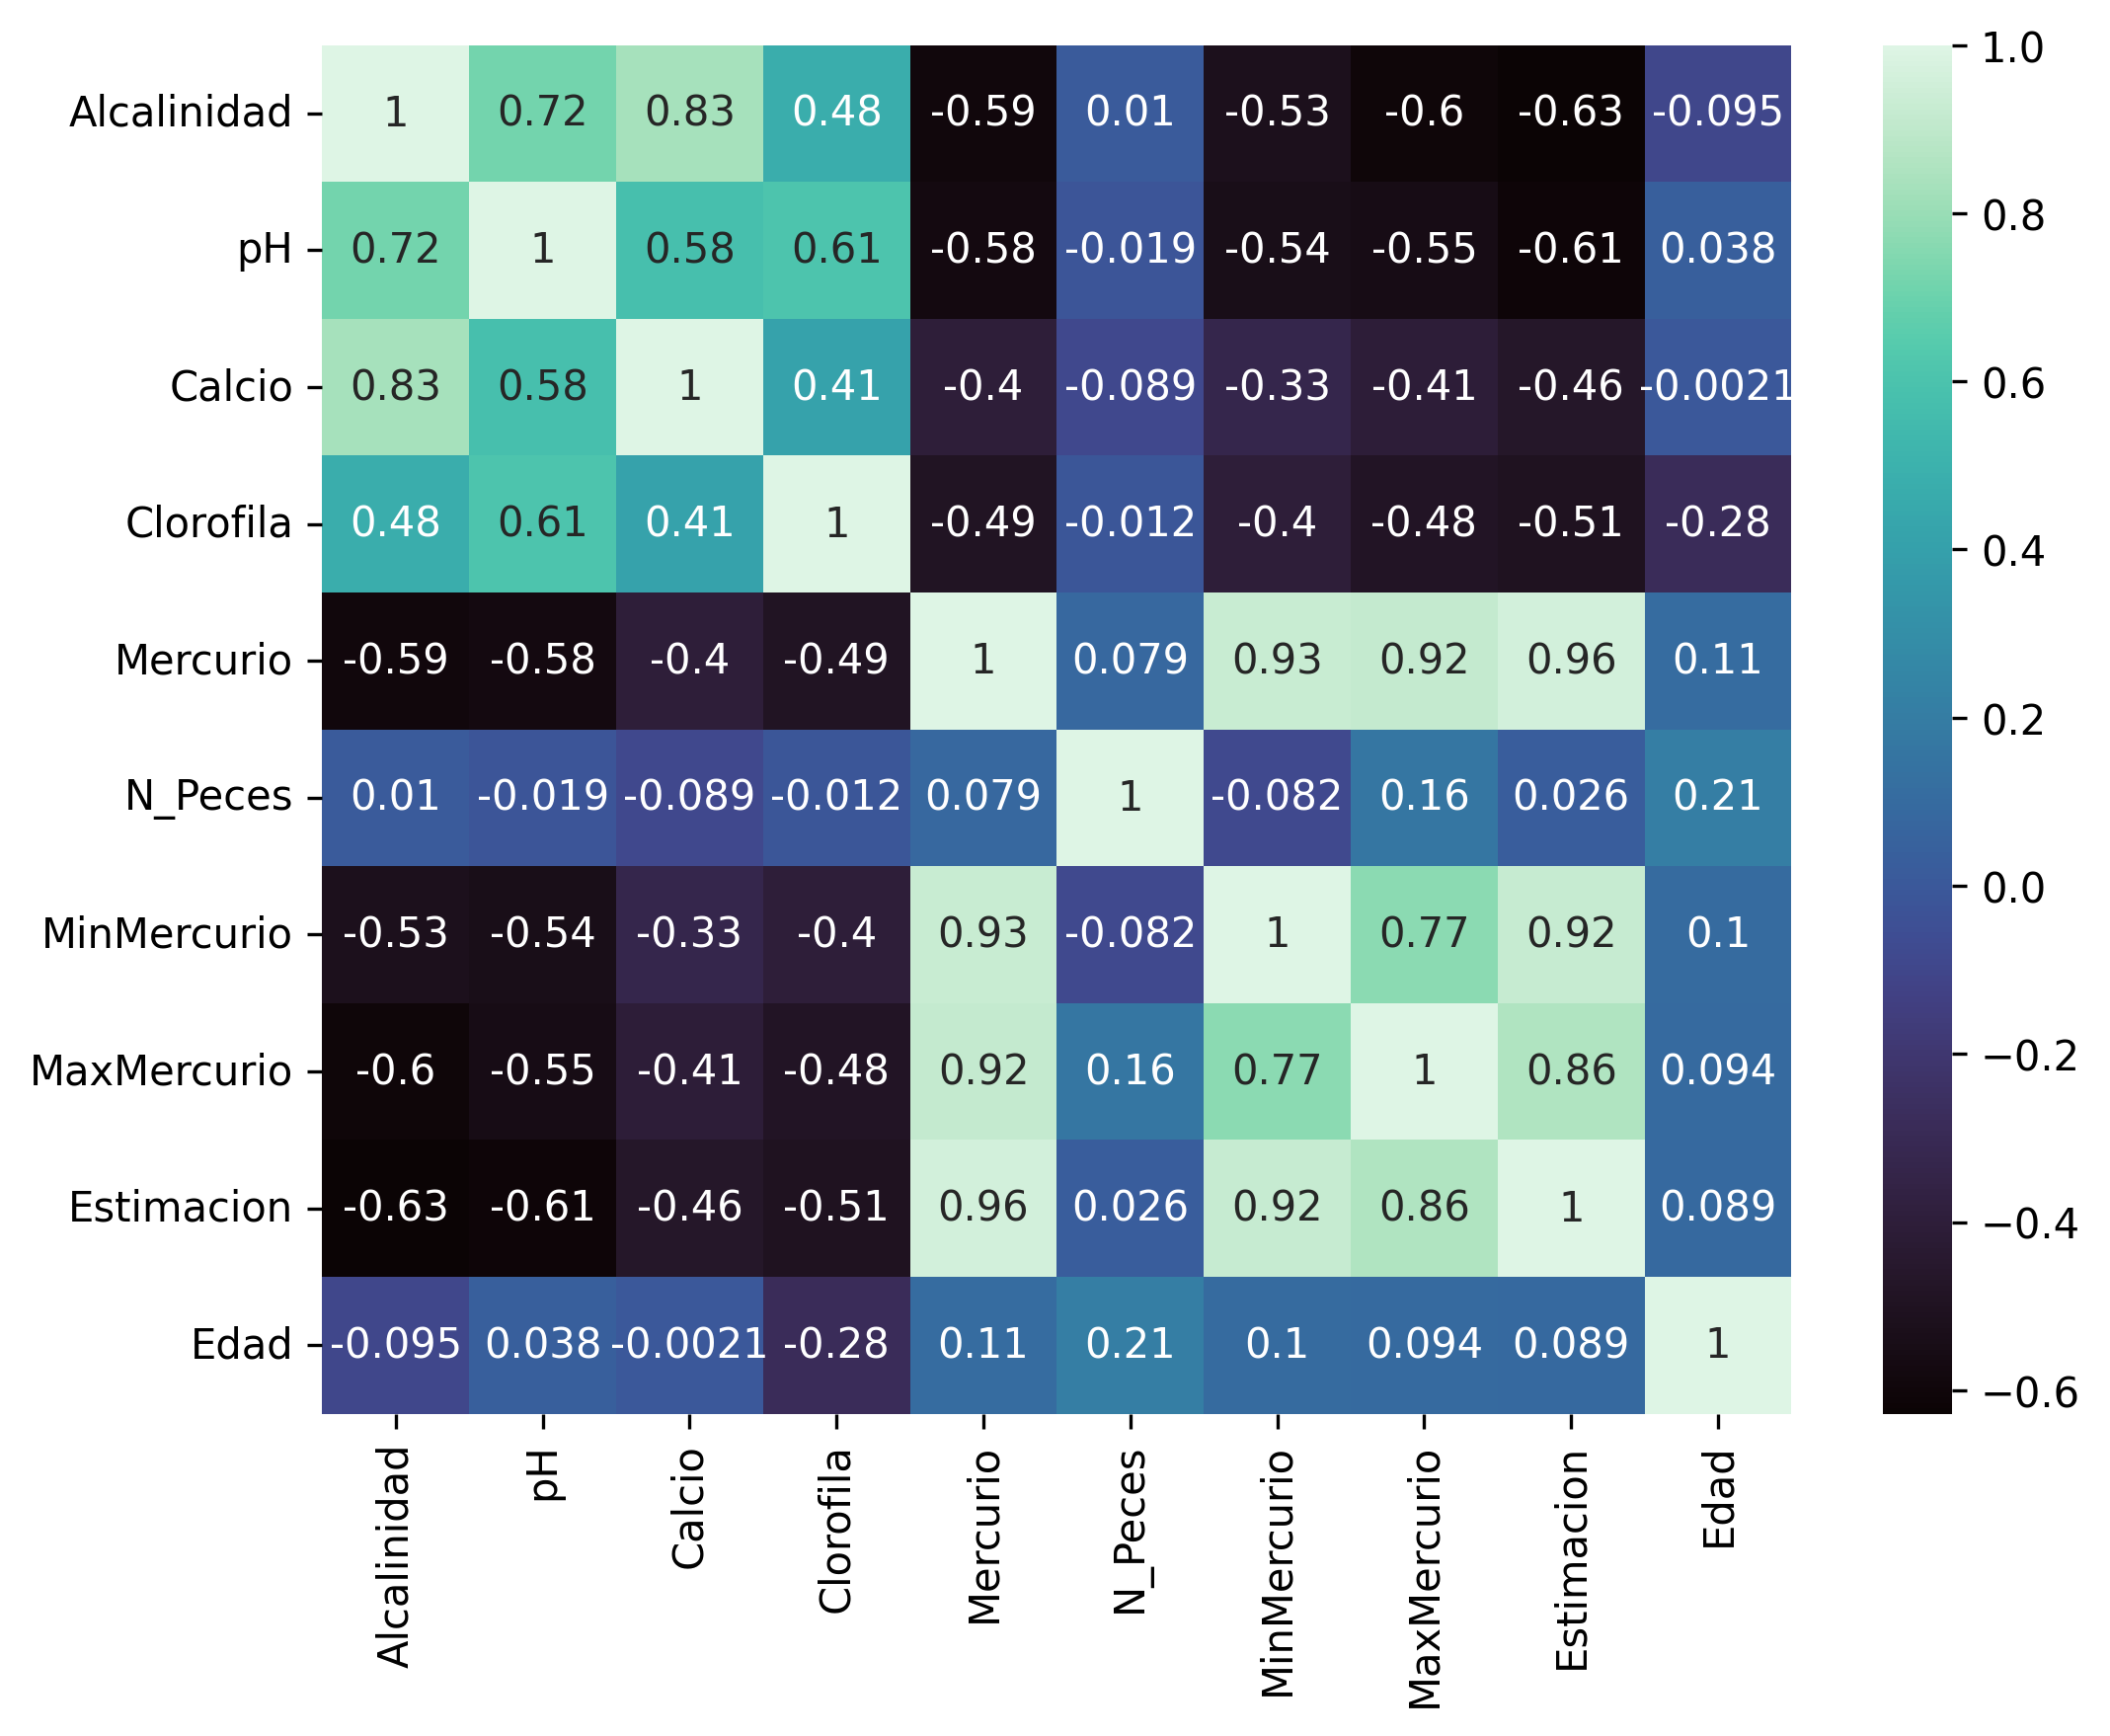

In [38]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot = True, cmap = "mako")
plt.show()

Y se observa que la variable de interés, Mercurio, tiene varias correlaciones importantes, a saber: alcalinidad, pH, clorofila, mínimo de mercurio, máximo de mercurio, y estimación. No obstante, se debe observar las correlaciones entre variables independientes; sucede que alcalinidad, clorofila y pH tienen una correlación considerable entre sí; asimismo, el mínimo, máximo y la estimación de mercurio también tienen fuerte colinealidad; además, mínimo, máximo y estimación poseen correlación con alcalinidad, pH y clorofila. Por lo tanto, para tener un modelo de regresión confiable se debe escoger únicamente una de estas variables, ya que la colinealidad entre todas es considerable. Se escoge la variable independiente con mayor correlación a la variable de respuesta, Estimación.

In [39]:
# x = df.drop(columns=["Lago"])
# for col in x.columns:
#     x[col], _ = stats.boxcox(df[col] + 1e-13)

In [40]:
lm = ols("Mercurio ~ Estimacion", 
         data = df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Mercurio   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     587.2
Date:                Tue, 13 Sep 2022   Prob (F-statistic):           1.20e-29
Time:                        18:00:18   Log-Likelihood:                 49.279
No. Observations:                  53   AIC:                            -94.56
Df Residuals:                      51   BIC:                            -90.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0315      0.024      1.291      0.2

Se obtiene un coeficiente de correlación de Pearson al cuadrado de $R^2 = 0.92$, lo cual indica un buen ajuste. Se debe notar que el coeficiente $\hat{\beta}_0$ no es significativo en la regresión de acuerdo con el p-value regresado por la función. Se procede a hacer el análisis de residuos para la verificación del modelo

# Verificación del modelo

Se extraen las predicciones del modelo con sus respectivos residuos.

In [41]:
y_model = lm.predict()     # Predicciones del modelo
e = lm.resid               # Residuos

Se visualizan las predicciones con respecto al valor real (variable de respuesta).

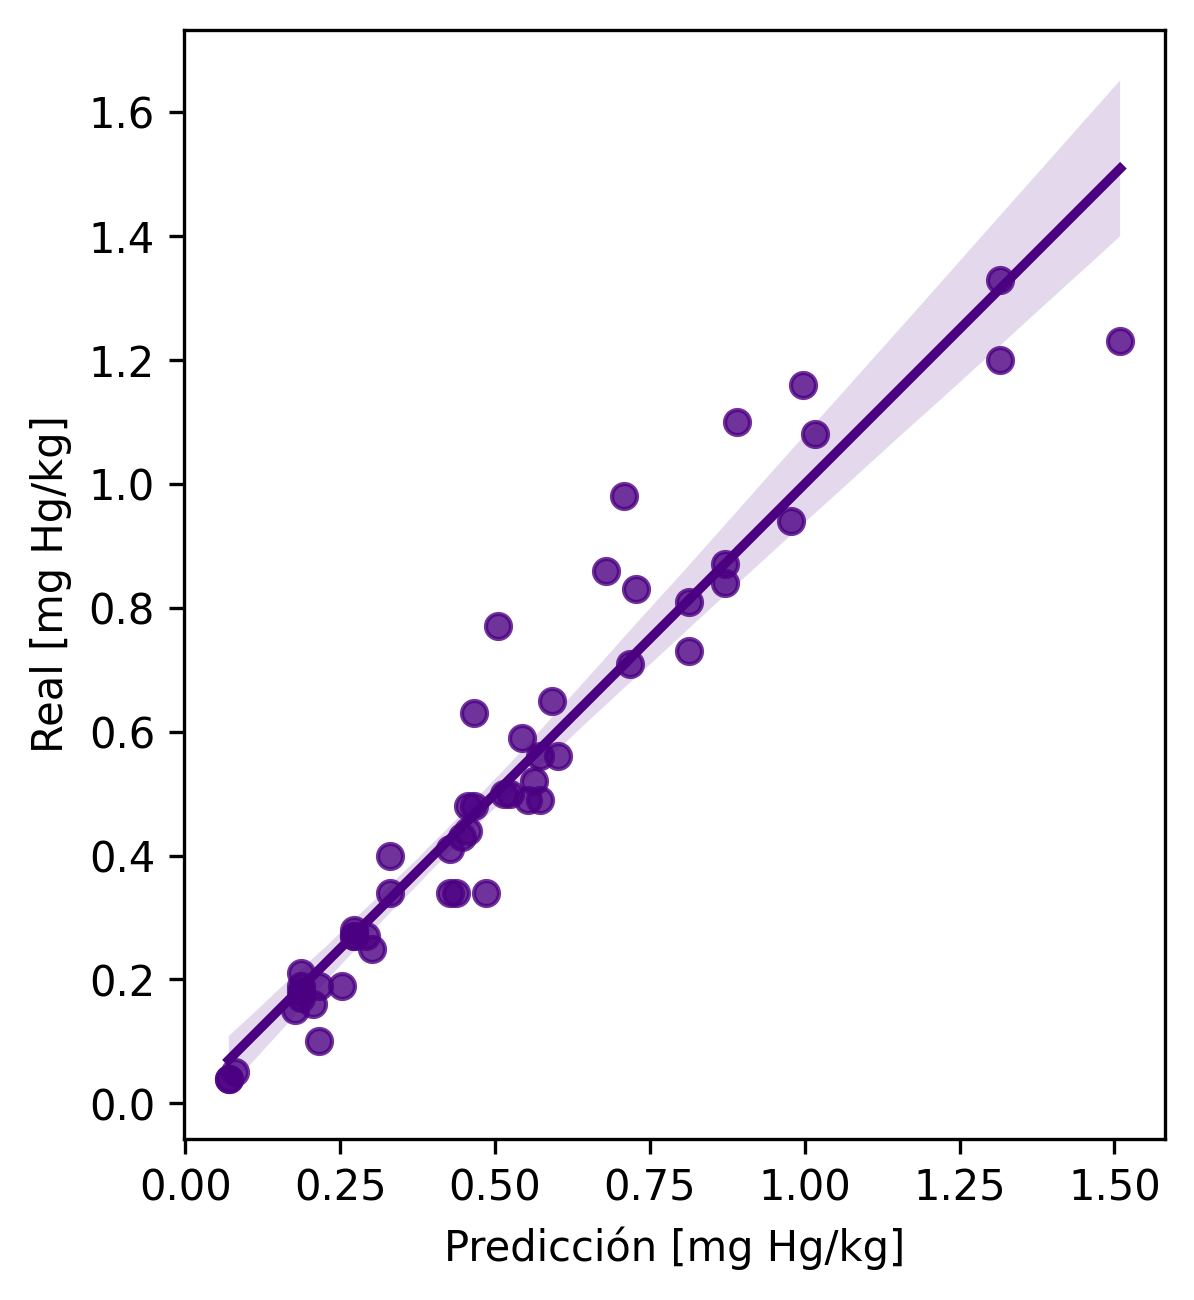

In [42]:
# sns.regplot(x = df.MinMercurio, y = df.Mercurio, color = "royalblue", label = r"Mínimo vs. Promedio")
sns.regplot(x = y_model, y = df.Mercurio, color = "indigo", label = r"Predicción vs. Real")
plt.xlabel("Predicción [mg Hg/kg]")
plt.ylabel("Real [mg Hg/kg]")
# plt.legend()
plt.axis("scaled")
plt.show()

## Normalidad de los residuos

Se comienza la verificación del modelo con una prueba de normalidad de Shapiro-Wilk de la distribución de los residuos.

In [43]:
s, p = stats.shapiro(e)
print("p-value: " + str(round(p, 4)))

p-value: 0.0002


Y la prueba regresa un p-value menor a un alfa estándar de $\alpha = 0.05$, por lo cual se rechaza la hipótesis nula; por lo tanto, se concluye con un nivel de significancia del 95% que los residuos no siguen una distribución normal. Se verifica esta aseveración gráficamente con un QQ-plot y un histograma

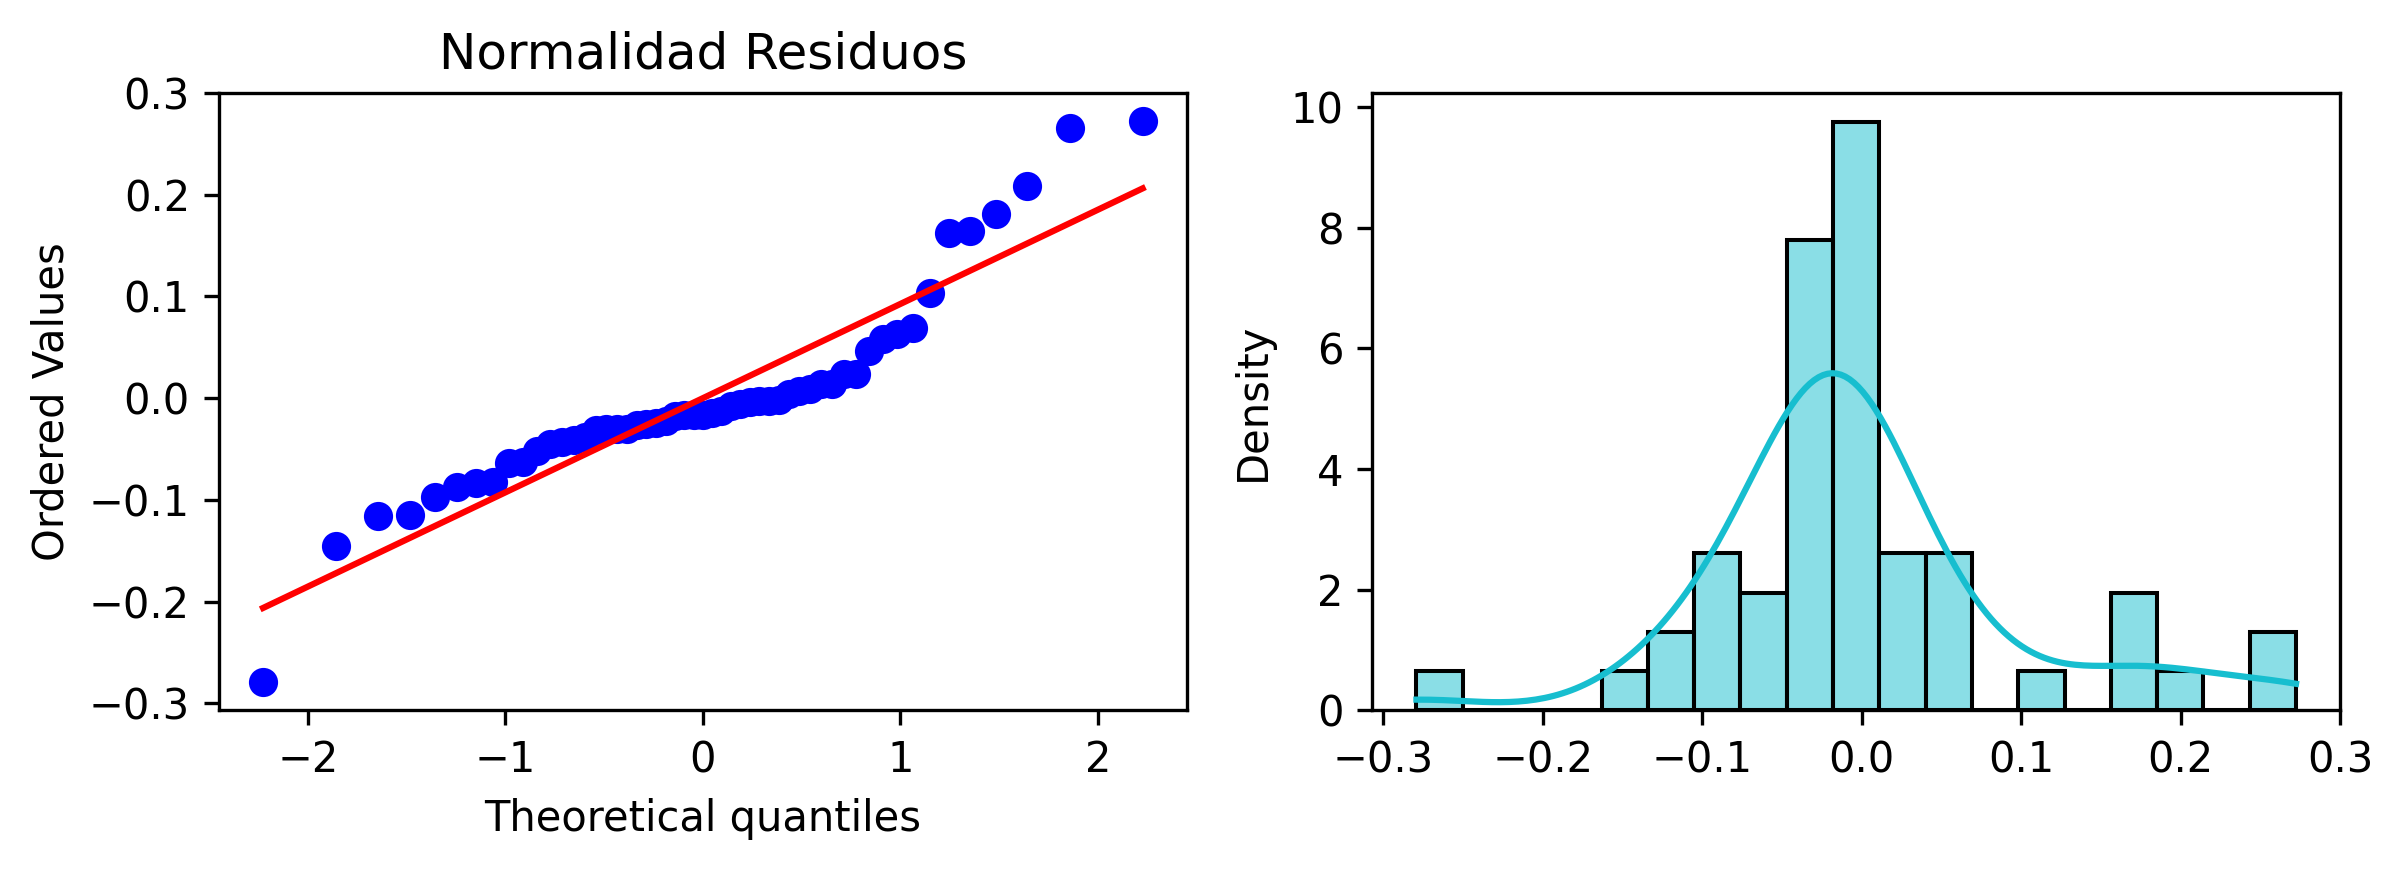

In [44]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
stats.probplot(e, plot = axes[0])
axes[0].set_title("Normalidad Residuos")
sns.histplot(x = e, kde = True, stat = "density", color = "tab:cyan", ax = axes[1])
plt.tight_layout()
plt.show()

Es notable la acumulación de residuos alrededor de 0-0.05. Esto, junto con la curtosis que se presenta en ambas colas, es lo que ocasiona un pobre ajuste a una distribución normal. Debido a que la regresión no cumplió con la suposición de normalidad de residuos, se rechaza la validez del modelo. Se puede proseguir a verificar los otros supuestos para identificar las posibles soluciones.

Se sigue con la prueba de hipótesis de independencia,

In [45]:
e_tstat, e_ind_pvalue = stats.ttest_1samp(e, popmean=0)

print("Media de los residuos", e.mean())
print("p-value:", e_ind_pvalue)

Media de los residuos 3.0190734608320886e-16
p-value: 0.9999999999999819


Debido a que el p-value es cercano a 1, no es posible rechazar la hipótesis nula que afirma que la media los residuos son igual a cero; por tanto, se conluye que la media de los residuos no es significativamente diferente de 0, confirmando la independencia de los mismos.

También se puede graficar la varianza de ls residuos para comprobar homocedasticidad.

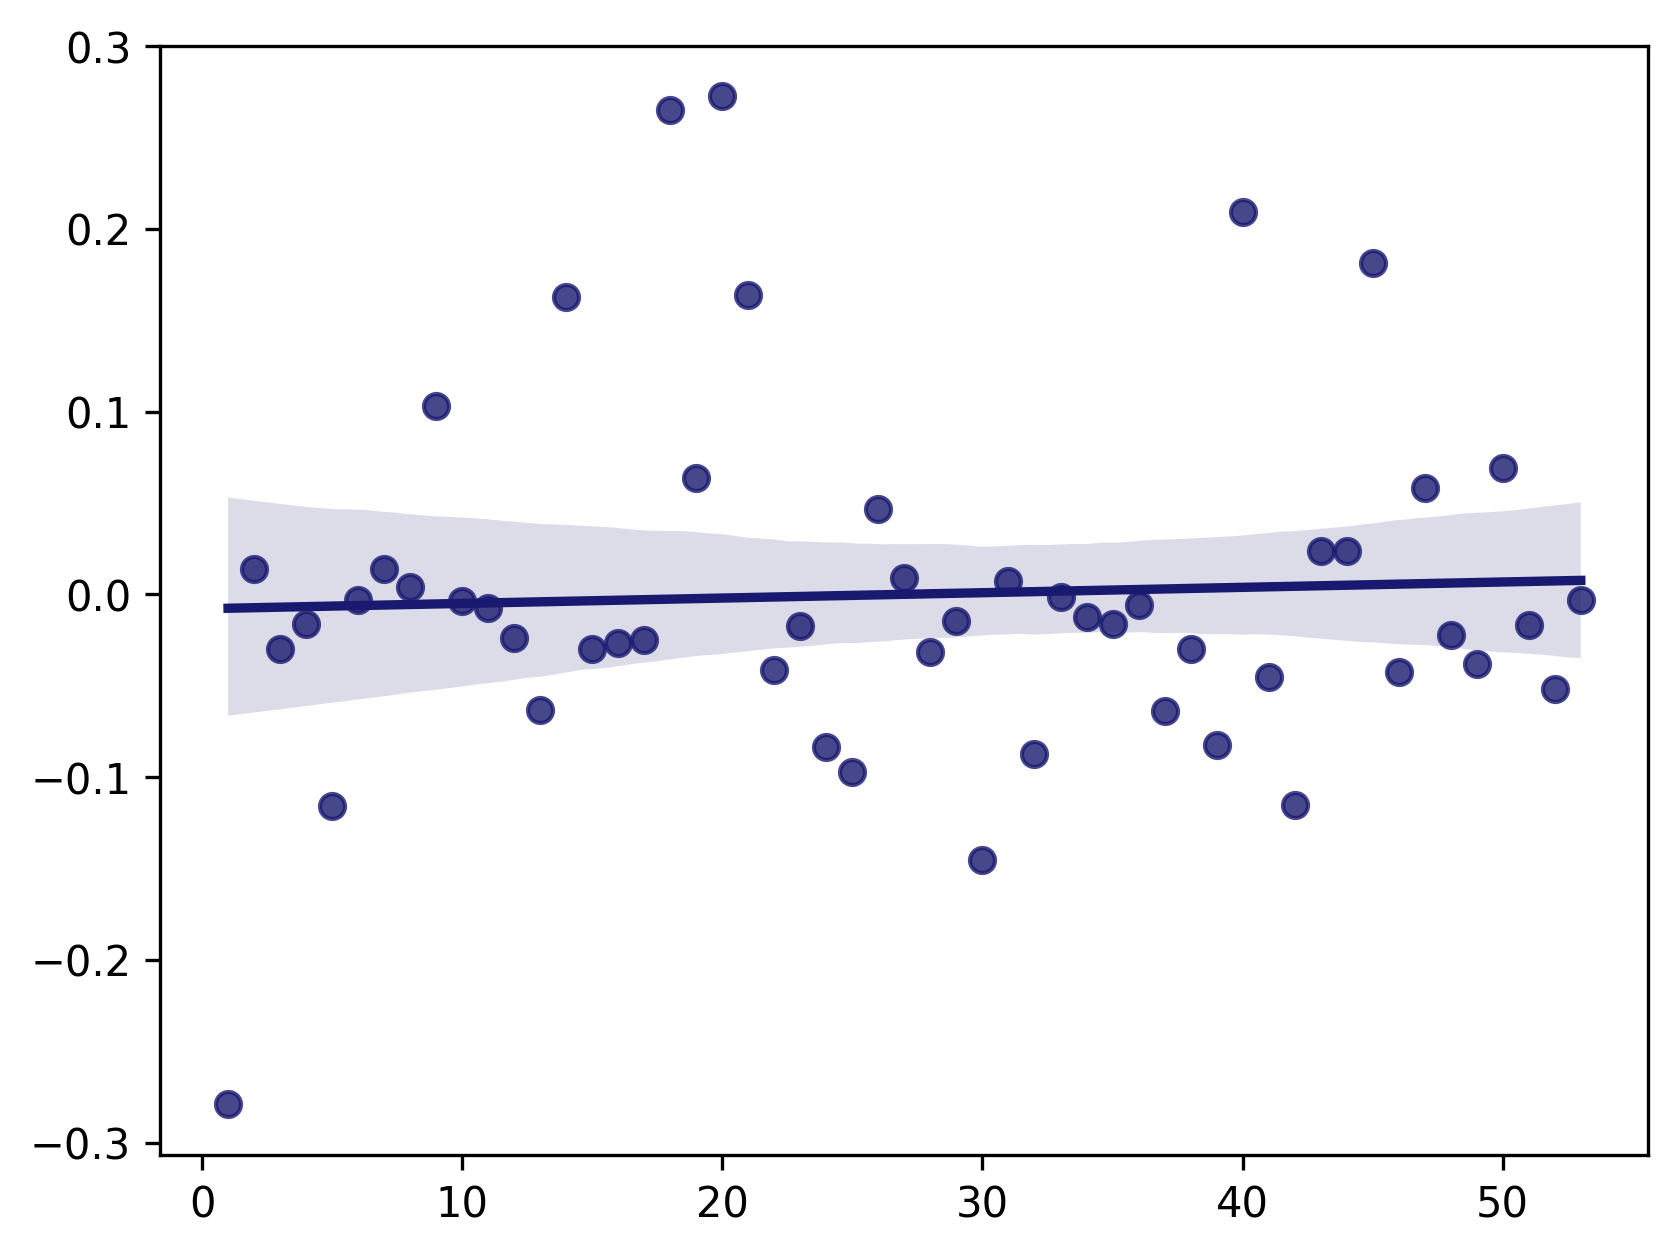

In [46]:
x = np.linspace(1, len(e), len(e))

sns.regplot(x = x, y = e, color = "midnightblue")
plt.show()

In [47]:
# AUTOCORRELATION TEST
# sm.stats.stattools.durbin_watson(e)

# Reformulación del modelo

In [48]:
df["Estimacion"], _ = stats.boxcox(df.Estimacion + 1e-13)
df["Mercurio"], _ = stats.boxcox(df.Mercurio + 1e-13)

In [49]:
lm = ols("Mercurio ~ Estimacion", 
         data = df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Mercurio   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     875.3
Date:                Tue, 13 Sep 2022   Prob (F-statistic):           8.89e-34
Time:                        18:00:19   Log-Likelihood:                 37.638
No. Observations:                  53   AIC:                            -71.28
Df Residuals:                      51   BIC:                            -67.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0076      0.028      0.274      0.7

In [50]:
y_model = lm.predict()     # Predicciones del modelo
e = lm.resid               # Residuos

In [51]:
s, p = stats.shapiro(e)
print("p-value: " + str(round(p, 4)))

p-value: 0.0626


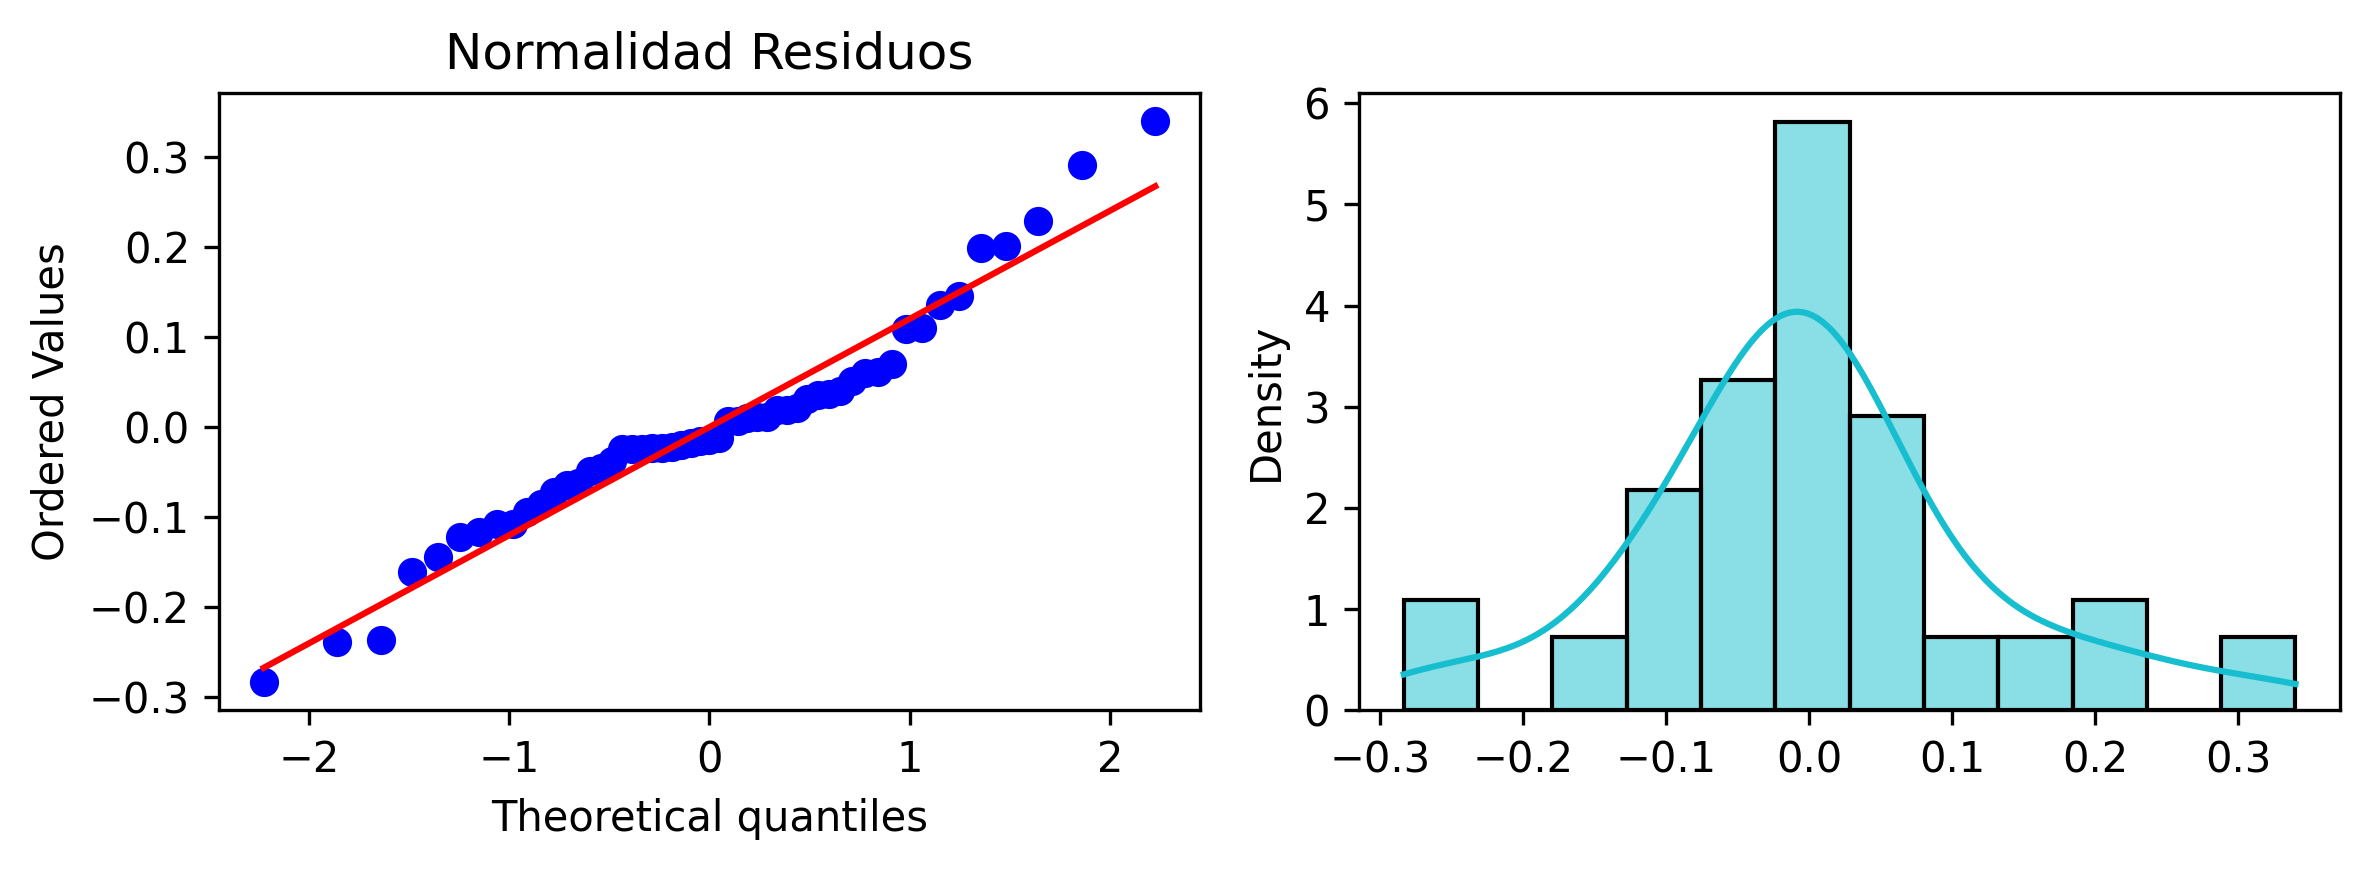

In [52]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
stats.probplot(e, plot = axes[0])
axes[0].set_title("Normalidad Residuos")
sns.histplot(x = e, kde = True, stat = "density", color = "tab:cyan", ax = axes[1])
plt.tight_layout()
plt.show()

In [53]:
e_tstat, e_ind_pvalue = stats.ttest_1samp(e, popmean=0)

print("Media de los residuos", e.mean())
print("p-value:", e_ind_pvalue)

Media de los residuos -6.860340388013939e-17
p-value: 0.9999999999999967


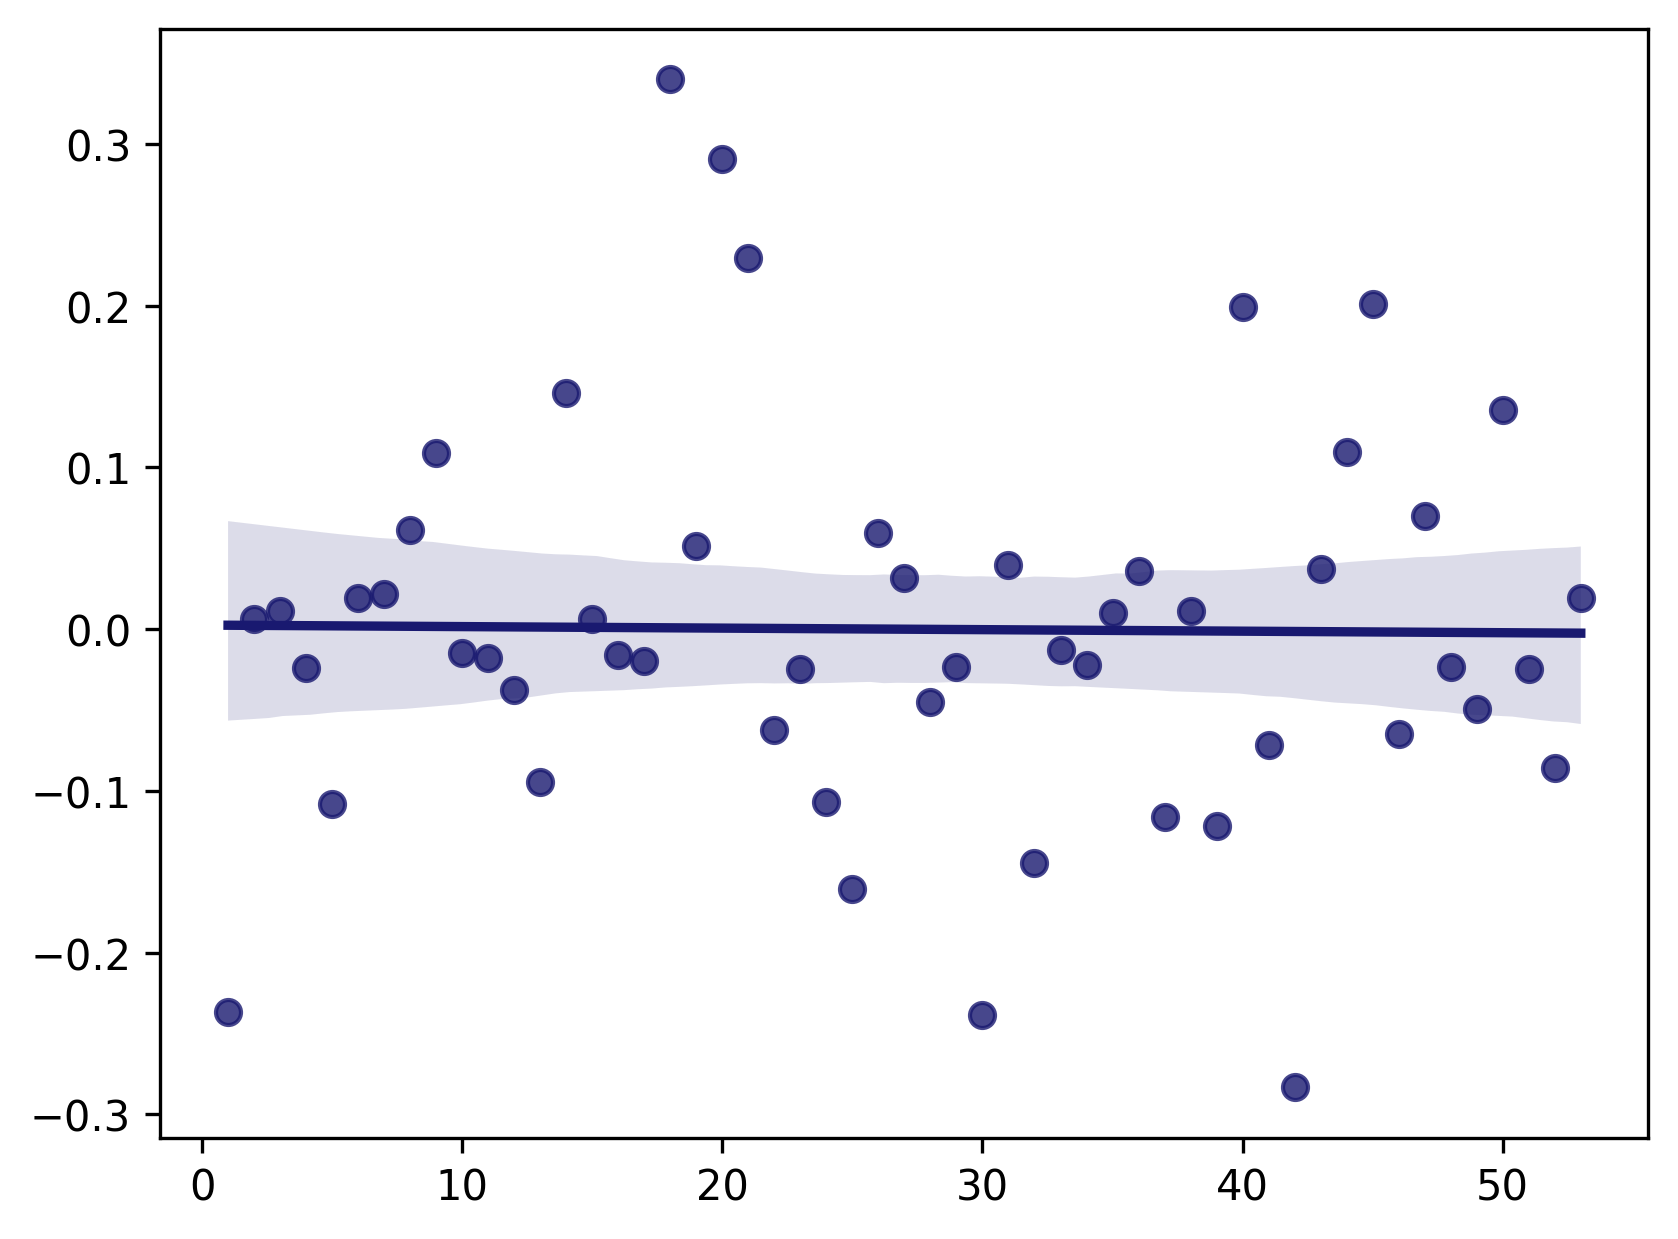

In [54]:
x = np.linspace(1, len(e), len(e))

sns.regplot(x = x, y = e, color = "midnightblue")
plt.show()